In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'No close LSTM Time Series - nonnoncyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from sklearn import preprocessing

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Non-Cyclic Stocks

### Kweichow Moutai Co., Ltd.

In [5]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14        OBV_7  labels
0  2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
1  2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2  2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
3  2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
4  2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


In [6]:
df.set_index('Date', inplace=True)

In [7]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [8]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [9]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
X.shape

(4106, 15, 3)

In [10]:
v = X.reshape(X.shape[0],15, 3)
v[0]

array([[0.56561183, 0.46282749, 0.22432246],
       [0.48559383, 0.32255128, 0.49006783],
       [0.19792211, 0.        , 0.17891161],
       [0.1505638 , 0.19881152, 0.55203919],
       [0.43087195, 0.52369458, 0.85164683],
       [0.5198189 , 0.37337444, 0.46466227],
       [0.33208159, 0.10667825, 0.19175134],
       [0.16844582, 0.12955741, 0.05083703],
       [0.11605662, 0.33580412, 0.17165809],
       [0.        , 0.3783434 , 0.        ],
       [0.19827315, 0.83077978, 0.30402389],
       [0.55253441, 1.        , 0.89587626],
       [0.6084195 , 0.60041228, 0.66894449],
       [1.        , 0.93732045, 1.        ],
       [0.75751779, 0.04412728, 0.39220808]])

In [11]:
y = labels
y = np.array(y)
y.shape

(4106,)

In [12]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [13]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [14]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [15]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [17]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
26/26 [==============================] - 1s 38ms/step - loss: 0.2861 - accuracy: 0.5110 - mse: 0.4591 - weighted_accuracy: 0.3448 - weighted_mse: 0.5332 - val_loss: 0.3011 - val_accuracy: 0.0511 - val_mse: 0.3461 - val_weighted_accuracy: 0.0511 - val_weighted_mse: 0.3461
Epoch 2/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2165 - accuracy: 0.4023 - mse: 0.7240 - weighted_accuracy: 0.4261 - weighted_mse: 0.7373 - val_loss: 0.2933 - val_accuracy: 0.0450 - val_mse: 0.3690 - val_weighted_accuracy: 0.0450 - val_weighted_mse: 0.3690
Epoch 3/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1951 - accuracy: 0.3267 - mse: 0.9456 - weighted_accuracy: 0.4583 - weighted_mse: 0.9397 - val_loss: 0.2854 - val_accuracy: 0.0450 - val_mse: 0.3987 - val_weighted_accuracy: 0.0450 - val_weighted_mse: 0.3987
Epoch 4/200
26/26 [==============================] - 0s 8ms/step - loss: 0.1841 - accuracy: 0.2905 - mse: 1.0831 - weighted_accuracy: 0.5230 - weighte

Epoch 30/200
26/26 [==============================] - 0s 8ms/step - loss: 0.1396 - accuracy: 0.3931 - mse: 1.6220 - weighted_accuracy: 0.7069 - weighted_mse: 1.5171 - val_loss: 0.1806 - val_accuracy: 0.4209 - val_mse: 1.4954 - val_weighted_accuracy: 0.4209 - val_weighted_mse: 1.4954
Epoch 31/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1387 - accuracy: 0.4373 - mse: 1.6022 - weighted_accuracy: 0.7078 - weighted_mse: 1.5093 - val_loss: 0.1909 - val_accuracy: 0.3601 - val_mse: 1.5878 - val_weighted_accuracy: 0.3601 - val_weighted_mse: 1.5878
Epoch 32/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1377 - accuracy: 0.4068 - mse: 1.6381 - weighted_accuracy: 0.7119 - weighted_mse: 1.5359 - val_loss: 0.1849 - val_accuracy: 0.3820 - val_mse: 1.5503 - val_weighted_accuracy: 0.3820 - val_weighted_mse: 1.5503
Epoch 33/200
26/26 [==============================] - 0s 8ms/step - loss: 0.1357 - accuracy: 0.4333 - mse: 1.6333 - weighted_accuracy: 0.7258 - weig

Epoch 59/200
26/26 [==============================] - 0s 8ms/step - loss: 0.1133 - accuracy: 0.5658 - mse: 2.0129 - weighted_accuracy: 0.8131 - weighted_mse: 1.9265 - val_loss: 0.1836 - val_accuracy: 0.4672 - val_mse: 2.0905 - val_weighted_accuracy: 0.4672 - val_weighted_mse: 2.0905
Epoch 60/200
26/26 [==============================] - 0s 8ms/step - loss: 0.1140 - accuracy: 0.5749 - mse: 2.0390 - weighted_accuracy: 0.8035 - weighted_mse: 1.9564 - val_loss: 0.1781 - val_accuracy: 0.4976 - val_mse: 2.0177 - val_weighted_accuracy: 0.4976 - val_weighted_mse: 2.0177
Epoch 61/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1119 - accuracy: 0.5603 - mse: 2.0421 - weighted_accuracy: 0.8024 - weighted_mse: 1.9499 - val_loss: 0.1667 - val_accuracy: 0.5414 - val_mse: 2.0713 - val_weighted_accuracy: 0.5414 - val_weighted_mse: 2.0713
Epoch 62/200
26/26 [==============================] - 0s 8ms/step - loss: 0.1122 - accuracy: 0.5597 - mse: 2.0848 - weighted_accuracy: 0.8022 - weig

Epoch 88/200
26/26 [==============================] - 0s 8ms/step - loss: 0.0926 - accuracy: 0.6790 - mse: 2.5684 - weighted_accuracy: 0.8675 - weighted_mse: 2.4945 - val_loss: 0.1967 - val_accuracy: 0.4915 - val_mse: 2.8135 - val_weighted_accuracy: 0.4915 - val_weighted_mse: 2.8135
Epoch 89/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0913 - accuracy: 0.6949 - mse: 2.5499 - weighted_accuracy: 0.8646 - weighted_mse: 2.4953 - val_loss: 0.1674 - val_accuracy: 0.5852 - val_mse: 2.6804 - val_weighted_accuracy: 0.5852 - val_weighted_mse: 2.6804
Epoch 90/200
26/26 [==============================] - 0s 8ms/step - loss: 0.0917 - accuracy: 0.6717 - mse: 2.6613 - weighted_accuracy: 0.8562 - weighted_mse: 2.5834 - val_loss: 0.1639 - val_accuracy: 0.5937 - val_mse: 2.6102 - val_weighted_accuracy: 0.5937 - val_weighted_mse: 2.6102
Epoch 91/200
26/26 [==============================] - 0s 8ms/step - loss: 0.0904 - accuracy: 0.6681 - mse: 2.6535 - weighted_accuracy: 0.8591 - weig

Epoch 117/200
26/26 [==============================] - 0s 8ms/step - loss: 0.0744 - accuracy: 0.7765 - mse: 3.4417 - weighted_accuracy: 0.9031 - weighted_mse: 3.3394 - val_loss: 0.1714 - val_accuracy: 0.6277 - val_mse: 3.7731 - val_weighted_accuracy: 0.6277 - val_weighted_mse: 3.7731
Epoch 118/200
26/26 [==============================] - 0s 8ms/step - loss: 0.0732 - accuracy: 0.7552 - mse: 3.5084 - weighted_accuracy: 0.9060 - weighted_mse: 3.3741 - val_loss: 0.1618 - val_accuracy: 0.6594 - val_mse: 3.5528 - val_weighted_accuracy: 0.6594 - val_weighted_mse: 3.5528
Epoch 119/200
26/26 [==============================] - 0s 8ms/step - loss: 0.0727 - accuracy: 0.7573 - mse: 3.4768 - weighted_accuracy: 0.9068 - weighted_mse: 3.3635 - val_loss: 0.1635 - val_accuracy: 0.6557 - val_mse: 3.4883 - val_weighted_accuracy: 0.6557 - val_weighted_mse: 3.4883
Epoch 120/200
26/26 [==============================] - 0s 8ms/step - loss: 0.0720 - accuracy: 0.7780 - mse: 3.5309 - weighted_accuracy: 0.9037 - 

Epoch 146/200
26/26 [==============================] - 0s 8ms/step - loss: 0.0610 - accuracy: 0.8246 - mse: 4.5199 - weighted_accuracy: 0.9207 - weighted_mse: 4.2873 - val_loss: 0.2029 - val_accuracy: 0.6241 - val_mse: 4.7560 - val_weighted_accuracy: 0.6241 - val_weighted_mse: 4.7560
Epoch 147/200
26/26 [==============================] - 0s 8ms/step - loss: 0.0592 - accuracy: 0.8115 - mse: 4.5103 - weighted_accuracy: 0.9267 - weighted_mse: 4.3189 - val_loss: 0.1501 - val_accuracy: 0.7482 - val_mse: 4.7755 - val_weighted_accuracy: 0.7482 - val_weighted_mse: 4.7755
Epoch 148/200
26/26 [==============================] - 0s 8ms/step - loss: 0.0596 - accuracy: 0.8167 - mse: 4.5349 - weighted_accuracy: 0.9286 - weighted_mse: 4.3009 - val_loss: 0.1765 - val_accuracy: 0.6703 - val_mse: 4.6470 - val_weighted_accuracy: 0.6703 - val_weighted_mse: 4.6470
Epoch 149/200
26/26 [==============================] - 0s 8ms/step - loss: 0.0561 - accuracy: 0.8252 - mse: 4.5870 - weighted_accuracy: 0.9338 - 

Epoch 175/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0459 - accuracy: 0.8736 - mse: 5.9139 - weighted_accuracy: 0.9537 - weighted_mse: 5.4282 - val_loss: 0.1902 - val_accuracy: 0.6873 - val_mse: 6.2554 - val_weighted_accuracy: 0.6873 - val_weighted_mse: 6.2554
Epoch 176/200
26/26 [==============================] - 0s 8ms/step - loss: 0.0479 - accuracy: 0.8672 - mse: 5.8725 - weighted_accuracy: 0.9492 - weighted_mse: 5.4433 - val_loss: 0.1863 - val_accuracy: 0.6849 - val_mse: 6.0311 - val_weighted_accuracy: 0.6849 - val_weighted_mse: 6.0311
Epoch 177/200
26/26 [==============================] - 0s 8ms/step - loss: 0.0466 - accuracy: 0.8742 - mse: 5.9751 - weighted_accuracy: 0.9518 - weighted_mse: 5.5334 - val_loss: 0.1940 - val_accuracy: 0.6873 - val_mse: 6.1693 - val_weighted_accuracy: 0.6873 - val_weighted_mse: 6.1693
Epoch 178/200
26/26 [==============================] - 0s 8ms/step - loss: 0.0473 - accuracy: 0.8590 - mse: 5.9978 - weighted_accuracy: 0.9419 - 

In [18]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.18714353442192078
Test accuracy: 0.7652068138122559


NameError: name 'logger' is not defined

In [ ]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

In [ ]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

In [ ]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
# Save model
model.save("models/{}".format('moutai_time_series_lstm_buy_hold_sell_no_close.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/moutai_time_series_lstm_buy_hold_sell_no_close.model\assets


### Test Performance

### non-recession

In [20]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [21]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   686.979980  640.790403 -10.183147  35030093.0     2.0
2019-01-23   671.000000  645.438034 -23.857615  30817872.0     2.0
2019-01-24   665.659973  648.549101 -28.427209  27455391.0     2.0
2019-01-25   672.500000  652.233855 -26.754575  30370918.0     2.0
2019-01-28   679.700012  656.459418 -19.452330  33269553.0     2.0


In [22]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [23]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [24]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(207, 15, 3)

In [25]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [26]:
model = tf.keras.models.load_model("models/moutai_time_series_lstm_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1841 - accuracy: 0.8019 - mean_squared_error: 8.1404 - weighted_accuracy: 0.8019 - weighted_mean_squared_error: 8.1404
Test loss: 0.18412581086158752
Test accuracy: 0.8019323945045471


In [27]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 181, 0: 19, 1: 7})

In [28]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 185, 0: 11, 1: 11})

In [29]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)

In [30]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-15,724.780029,700.682442,-8.071529,46243699.0,2.0,2,2
2019-02-18,740.000000,704.389763,-23.444619,43919901.0,2.0,2,2
2019-02-19,730.760010,709.868261,-6.049880,47694490.0,2.0,2,2
2019-02-20,722.000000,713.082376,-17.677836,44744340.0,2.0,2,2
2019-02-21,720.250000,714.454318,-29.824573,40956103.0,2.0,2,2


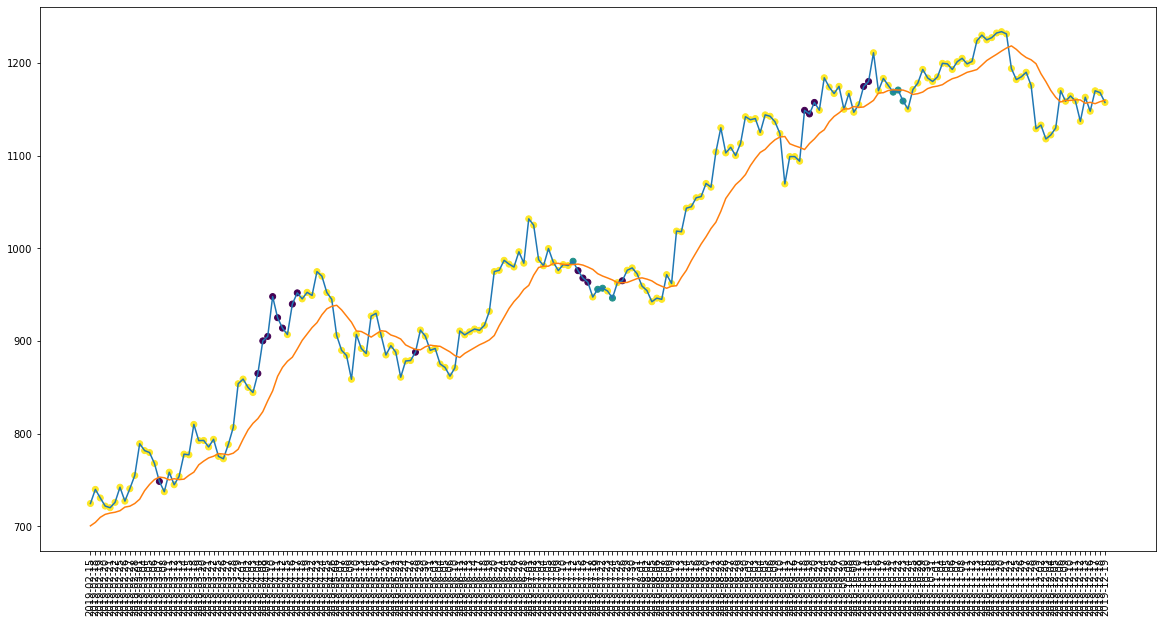

In [31]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [32]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 207
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 6
actual holds but predicted sell: 16
actual predicted holds: 163
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 18.181818181818183%
Percentage holds correct: 88.10810810810811%
actual buys: 11
actual sells: 11
actual holds: 185


In [33]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[720.25, 722.0, 724.780029296875, 726.010009765625, 727.3499755859375, 730.760009765625, 740.0, 740.7000122070312, 742.3300170898438]
[727.3499755859375, 740.7000122070312, 742.3300170898438, 748.5999755859375, 755.010009765625, 768.0, 779.780029296875, 781.8599853515625, 789.2999877929688]
Percentage buys correct: 57.142857142857146%
Percentage sells correct: 42.10526315789474%
Percentage holds correct: 85.0828729281768%


In [34]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $986.0900268554688
Shares owned at the moment: 10
Cash capital at the moment: $111.98225570678733


Stop Loss Activated!

Share price: $947.5
Shares owned at the moment: 0
Cash capital at the moment: $9560.926005706788


Share price: $955.8699951171876
Shares owned at the moment: 9
Cash capital at the moment: $934.438267272948


Price increase from previously bought: 19.86454433428353%
Share price: $1148.9000244140625
Shares owned at the moment: 0
Cash capital at the moment: $11246.103211395262


Share price: $1168.5
Shares owned at the moment: 9
Cash capital at the moment: $700.6828363952627


Stop Loss Activated!

Share price: $1129.0
Shares owned at the moment: 0
Cash capital at the moment: $10833.740086395263




Capital at the end of test period: $10833.740086395263
profit gained: 8.337400863952626%


In [35]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $15556.77199960327
profit gained: 55.56771999603271%


In [36]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.801932,9.090909090909092%,18.181818181818183%,88.10810810810811%,57.142857142857146%,42.10526315789474%,85.0828729281768%,8.337400863952626%,55.56771999603271%


### Recession

In [37]:
logger = []

In [38]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2020-01-22  1075.300049  1097.577291 -89.711935   1200864.0     2.0
2020-01-23  1075.510010  1094.182325 -70.779503   4820868.0     2.0
2020-02-03  1052.800049  1087.815821 -81.895216   -525975.0     1.0
2020-02-04  1003.919983  1074.908769 -83.419991 -12870263.0     2.0
2020-02-05  1038.010010  1069.232037 -59.790669  -6607845.0     2.0


In [39]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [40]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [41]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(208, 15, 3)

In [42]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [43]:
model = tf.keras.models.load_model("models/moutai_time_series_lstm_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1849 - accuracy: 0.7885 - mean_squared_error: 7.2265 - weighted_accuracy: 0.7885 - weighted_mean_squared_error: 7.2265
Test loss: 0.18490482866764069
Test accuracy: 0.7884615659713745


In [44]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 181, 0: 20, 1: 7})

In [45]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [46]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)

In [47]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-18,1084.000000,1082.243470,-14.989967,2243205.0,2.0,2,2
2020-02-19,1096.500000,1082.513705,-22.324305,-423291.0,2.0,2,0
2020-02-20,1118.000000,1084.665443,-12.988283,3281856.0,0.0,2,2
2020-02-21,1112.880005,1089.793836,-4.166667,7962118.0,2.0,2,2
2020-02-24,1087.180054,1093.345554,-10.201830,5068110.0,2.0,2,2


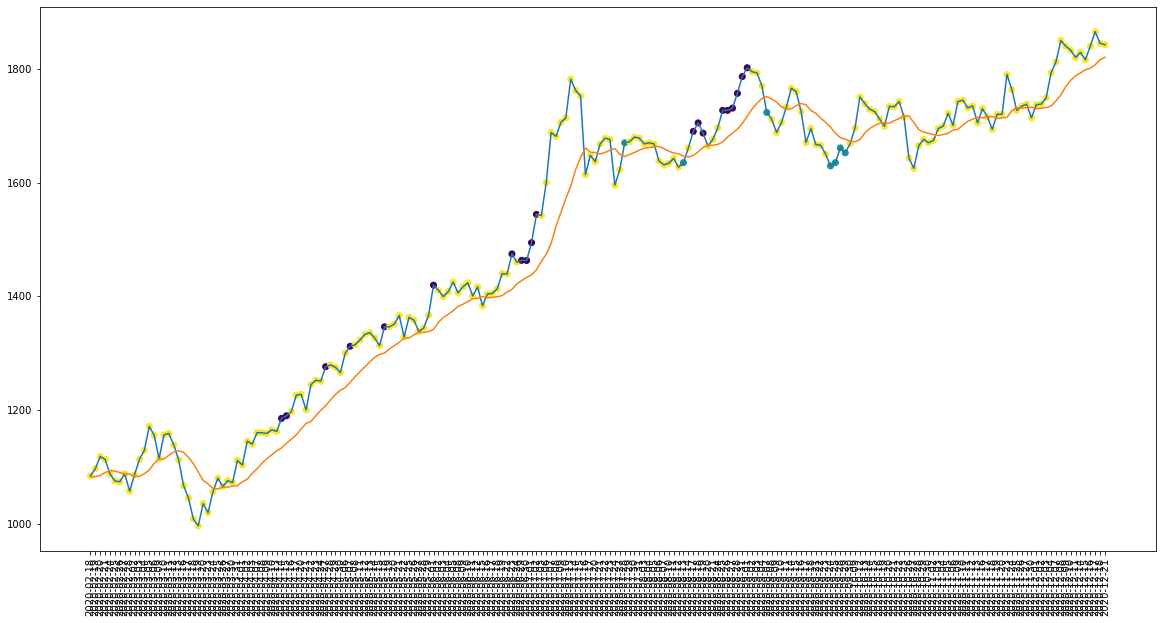

In [48]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [49]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 208
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 7
actual holds but predicted sell: 19
actual predicted holds: 163
Percentage buys correct: 0.0%
Percentage sells correct: 10.0%
Percentage holds correct: 86.24338624338624%
actual buys: 9
actual sells: 10
actual holds: 189


In [50]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[1057.0, 1073.699951171875, 1074.81005859375, 1084.0, 1087.1800537109377, 1087.3900146484377, 1096.5, 1112.8800048828123, 1118.0]
[1057.0, 1073.699951171875, 1086.010009765625, 1087.3900146484377, 1113.0, 1114.010009765625, 1128.9200439453125, 1155.5, 1171.0]
Percentage buys correct: 85.71428571428571%
Percentage sells correct: 50.0%
Percentage holds correct: 84.5303867403315%


In [51]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $1670.0
Shares owned at the moment: 5
Cash capital at the moment: $1627.0375000000004


Price increase from previously bought: 6.682670560151194%
Share price: $1786.5
Shares owned at the moment: 0
Cash capital at the moment: $10534.973125


Share price: $1723.5
Shares owned at the moment: 6
Cash capital at the moment: $165.53537499999948


Stop Loss Activated!

Share price: $1670.52001953125
Shares owned at the moment: 0
Cash capital at the moment: $10161.091911865233


Share price: $1629.3199462890625
Shares owned at the moment: 6
Cash capital at the moment: $358.2884550170875




Capital at the end of test period: $11382.887205017087
profit gained: 13.828872050170867%


In [52]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16754.069125
profit gained: 67.54069125000002%


In [53]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.801932,9.090909090909092%,18.181818181818183%,88.10810810810811%,57.142857142857146%,42.10526315789474%,85.0828729281768%,8.337400863952626%,55.56771999603271%
1,0.788462,0.0%,10.0%,86.24338624338624%,85.71428571428571%,50.0%,84.5303867403315%,13.828872050170867%,67.54069125000002%


### Midea Group

In [54]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14        OBV_7  labels
0  2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
1  2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2  2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
3  2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
4  2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


In [55]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2013-10-17,11.912000,11.900182,-34.022038,235647532.0,1.0
2013-10-18,11.896000,11.899539,-39.103542,214825024.0,2.0
2013-10-21,12.269333,11.956430,-24.093825,253903732.0,2.0
2013-10-22,12.760000,12.080056,-4.424713,304775737.0,2.0
2013-10-23,12.645333,12.167022,-15.187657,273970459.0,2.0


In [56]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [57]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [58]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
X.shape

(1253, 15, 3)

In [59]:
y = labels
y = np.array(y)

In [60]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [61]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [62]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [64]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
8/8 [==============================] - 1s 93ms/step - loss: 0.3172 - accuracy: 0.5409 - mse: 0.3605 - weighted_accuracy: 0.3532 - weighted_mse: 0.4521 - val_loss: 0.3041 - val_accuracy: 0.1155 - val_mse: 0.3391 - val_weighted_accuracy: 0.1155 - val_weighted_mse: 0.3391
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 0.2685 - accuracy: 0.4741 - mse: 0.4478 - weighted_accuracy: 0.3654 - weighted_mse: 0.5035 - val_loss: 0.3031 - val_accuracy: 0.1155 - val_mse: 0.3424 - val_weighted_accuracy: 0.1155 - val_weighted_mse: 0.3424
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 0.2407 - accuracy: 0.4351 - mse: 0.5426 - weighted_accuracy: 0.4719 - weighted_mse: 0.5730 - val_loss: 0.3013 - val_accuracy: 0.0956 - val_mse: 0.3437 - val_weighted_accuracy: 0.0956 - val_weighted_mse: 0.3437
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.2216 - accuracy: 0.3852 - mse: 0.6329 - weighted_accuracy: 0.4903 - weighted_mse

8/8 [==============================] - 0s 9ms/step - loss: 0.1415 - accuracy: 0.4301 - mse: 1.2718 - weighted_accuracy: 0.7619 - weighted_mse: 1.2190 - val_loss: 0.2373 - val_accuracy: 0.0757 - val_mse: 0.6956 - val_weighted_accuracy: 0.0757 - val_weighted_mse: 0.6956
Epoch 31/200
8/8 [==============================] - 0s 9ms/step - loss: 0.1405 - accuracy: 0.4391 - mse: 1.2783 - weighted_accuracy: 0.7588 - weighted_mse: 1.2262 - val_loss: 0.2346 - val_accuracy: 0.0757 - val_mse: 0.7121 - val_weighted_accuracy: 0.0757 - val_weighted_mse: 0.7121
Epoch 32/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1406 - accuracy: 0.4621 - mse: 1.2716 - weighted_accuracy: 0.7736 - weighted_mse: 1.2318 - val_loss: 0.2325 - val_accuracy: 0.0797 - val_mse: 0.7287 - val_weighted_accuracy: 0.0797 - val_weighted_mse: 0.7287
Epoch 33/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1384 - accuracy: 0.4581 - mse: 1.2869 - weighted_accuracy: 0.7744 - weighted_mse: 1.2466 - v

8/8 [==============================] - 0s 9ms/step - loss: 0.1114 - accuracy: 0.5609 - mse: 1.5077 - weighted_accuracy: 0.8326 - weighted_mse: 1.4403 - val_loss: 0.1696 - val_accuracy: 0.6454 - val_mse: 1.1060 - val_weighted_accuracy: 0.6454 - val_weighted_mse: 1.1060
Epoch 60/200
8/8 [==============================] - 0s 9ms/step - loss: 0.1108 - accuracy: 0.5619 - mse: 1.4995 - weighted_accuracy: 0.8254 - weighted_mse: 1.4529 - val_loss: 0.1668 - val_accuracy: 0.6653 - val_mse: 1.1241 - val_weighted_accuracy: 0.6653 - val_weighted_mse: 1.1241
Epoch 61/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1086 - accuracy: 0.6048 - mse: 1.5113 - weighted_accuracy: 0.8551 - weighted_mse: 1.4627 - val_loss: 0.1649 - val_accuracy: 0.6614 - val_mse: 1.1420 - val_weighted_accuracy: 0.6614 - val_weighted_mse: 1.1420
Epoch 62/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1099 - accuracy: 0.6008 - mse: 1.5359 - weighted_accuracy: 0.8461 - weighted_mse: 1.4785 - 

8/8 [==============================] - 0s 9ms/step - loss: 0.0883 - accuracy: 0.6906 - mse: 1.9025 - weighted_accuracy: 0.8866 - weighted_mse: 1.8359 - val_loss: 0.1598 - val_accuracy: 0.6135 - val_mse: 1.6307 - val_weighted_accuracy: 0.6135 - val_weighted_mse: 1.6307
Epoch 89/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0880 - accuracy: 0.7006 - mse: 1.9131 - weighted_accuracy: 0.8902 - weighted_mse: 1.8420 - val_loss: 0.1516 - val_accuracy: 0.6653 - val_mse: 1.6630 - val_weighted_accuracy: 0.6653 - val_weighted_mse: 1.6630
Epoch 90/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0894 - accuracy: 0.7265 - mse: 1.9329 - weighted_accuracy: 0.8997 - weighted_mse: 1.8704 - val_loss: 0.1524 - val_accuracy: 0.6534 - val_mse: 1.7306 - val_weighted_accuracy: 0.6534 - val_weighted_mse: 1.7306
Epoch 91/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0859 - accuracy: 0.7036 - mse: 1.9566 - weighted_accuracy: 0.8913 - weighted_mse: 1.8976 - v

8/8 [==============================] - 0s 9ms/step - loss: 0.0684 - accuracy: 0.7874 - mse: 2.5040 - weighted_accuracy: 0.9221 - weighted_mse: 2.3899 - val_loss: 0.1566 - val_accuracy: 0.7410 - val_mse: 2.5708 - val_weighted_accuracy: 0.7410 - val_weighted_mse: 2.5708
Epoch 118/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0686 - accuracy: 0.7874 - mse: 2.5354 - weighted_accuracy: 0.9221 - weighted_mse: 2.4179 - val_loss: 0.1626 - val_accuracy: 0.7052 - val_mse: 2.6474 - val_weighted_accuracy: 0.7052 - val_weighted_mse: 2.6474
Epoch 119/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0667 - accuracy: 0.7685 - mse: 2.5803 - weighted_accuracy: 0.9151 - weighted_mse: 2.4520 - val_loss: 0.1609 - val_accuracy: 0.7211 - val_mse: 2.7043 - val_weighted_accuracy: 0.7211 - val_weighted_mse: 2.7043
Epoch 120/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0662 - accuracy: 0.8044 - mse: 2.5933 - weighted_accuracy: 0.9283 - weighted_mse: 2.4654

Epoch 146/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0517 - accuracy: 0.8463 - mse: 3.3049 - weighted_accuracy: 0.9437 - weighted_mse: 3.0436 - val_loss: 0.1795 - val_accuracy: 0.7211 - val_mse: 3.6013 - val_weighted_accuracy: 0.7211 - val_weighted_mse: 3.6013
Epoch 147/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0510 - accuracy: 0.8533 - mse: 3.3404 - weighted_accuracy: 0.9462 - weighted_mse: 3.0703 - val_loss: 0.1730 - val_accuracy: 0.7211 - val_mse: 3.4205 - val_weighted_accuracy: 0.7211 - val_weighted_mse: 3.4205
Epoch 148/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0532 - accuracy: 0.8623 - mse: 3.3524 - weighted_accuracy: 0.9495 - weighted_mse: 3.0526 - val_loss: 0.1612 - val_accuracy: 0.7729 - val_mse: 3.6429 - val_weighted_accuracy: 0.7729 - val_weighted_mse: 3.6429
Epoch 149/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0515 - accuracy: 0.8573 - mse: 3.3676 - weighted_accuracy: 0.9412 - weighte

Epoch 175/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0376 - accuracy: 0.9012 - mse: 4.3713 - weighted_accuracy: 0.9638 - weighted_mse: 3.8124 - val_loss: 0.1979 - val_accuracy: 0.7371 - val_mse: 4.5641 - val_weighted_accuracy: 0.7371 - val_weighted_mse: 4.5641
Epoch 176/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0384 - accuracy: 0.8902 - mse: 4.4030 - weighted_accuracy: 0.9598 - weighted_mse: 3.8554 - val_loss: 0.1937 - val_accuracy: 0.7649 - val_mse: 4.5845 - val_weighted_accuracy: 0.7649 - val_weighted_mse: 4.5845
Epoch 177/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0375 - accuracy: 0.8962 - mse: 4.4697 - weighted_accuracy: 0.9619 - weighted_mse: 3.9087 - val_loss: 0.1966 - val_accuracy: 0.7610 - val_mse: 4.5611 - val_weighted_accuracy: 0.7610 - val_weighted_mse: 4.5611
Epoch 178/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0376 - accuracy: 0.9082 - mse: 4.4999 - weighted_accuracy: 0.9663 - weighted

In [65]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.21336738765239716
Test accuracy: 0.7689242959022522


In [66]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-4.0361443  -2.9612408   2.550668  ]
 [ 0.08992345 -3.4654236  -0.2249757 ]
 [-4.2416544  -1.7023566   1.7230383 ]
 [-2.3114884  -0.28173333 -0.373261  ]
 [-1.6752858  -2.1161094   0.5427205 ]
 [-1.315219   -2.006898    0.80529237]
 [-3.7856658  -2.3691082   0.65456486]
 [-0.14045043 -1.6555606  -2.2453861 ]
 [-2.5323334  -1.8908471   0.13705492]
 [-0.01928955 -3.5662642  -0.03680354]
 [-2.7084866  -2.9066672   2.150403  ]
 [-1.3307078  -3.683838    0.99867415]
 [-2.5943224  -5.119183    2.364541  ]
 [-3.4217694  -4.0623198   2.2932577 ]
 [-2.343564   -5.353583    2.2157204 ]
 [-1.4027122  -2.473943    0.31906262]
 [-3.403101   -2.0903308   1.2051836 ]
 [-1.015748   -0.7097818  -1.0003022 ]
 [-2.284934   -2.621127    1.6866813 ]
 [-0.9934416  -3.0902805   0.93231624]
 [-1.9243276  -3.3086643   1.3540413 ]
 [-2.0382788  -0.31561276 -0.9382933 ]
 [-1.9892592  -2.1220427   0.2800807 ]
 [-0.59389275 -2.8590124   0.2948865 ]
 [ 1.1666306  -3.0735445  -0.8236875 ]
 [-2.5573535  -2.823083  

Counter({2: 214, 0: 17, 1: 20})

In [67]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 228, 1: 13, 0: 10})

In [68]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 251
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 12
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 19
actual holds but predicted sell: 17
actual predicted holds: 192
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 0.0%
Percentage holds correct: 84.21052631578948%
actual buys: 13
actual sells: 10
actual holds: 228


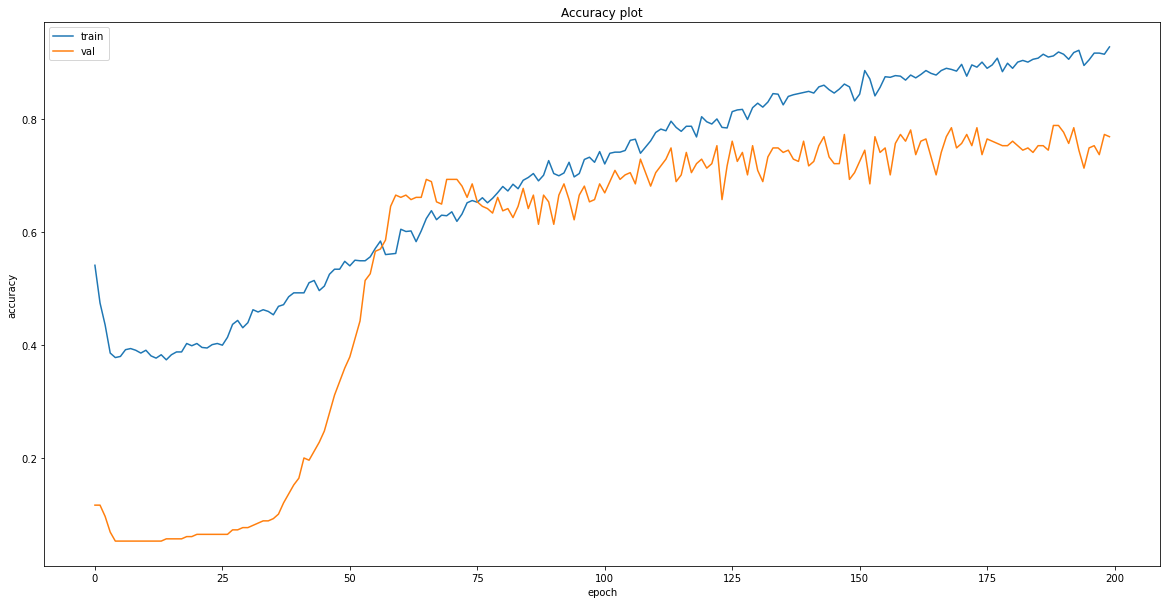

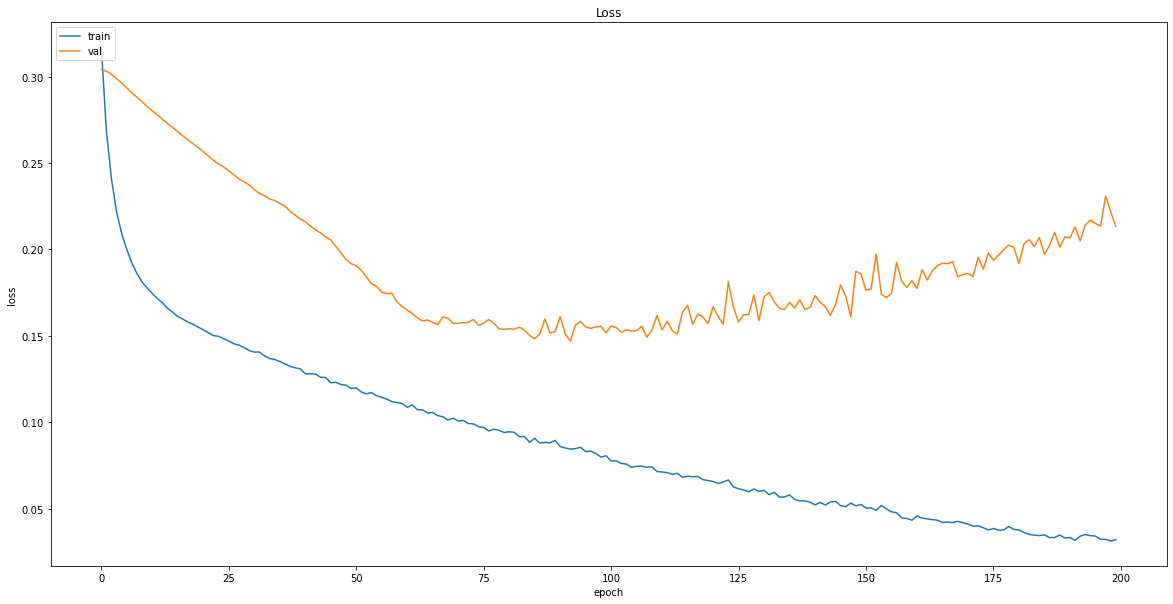

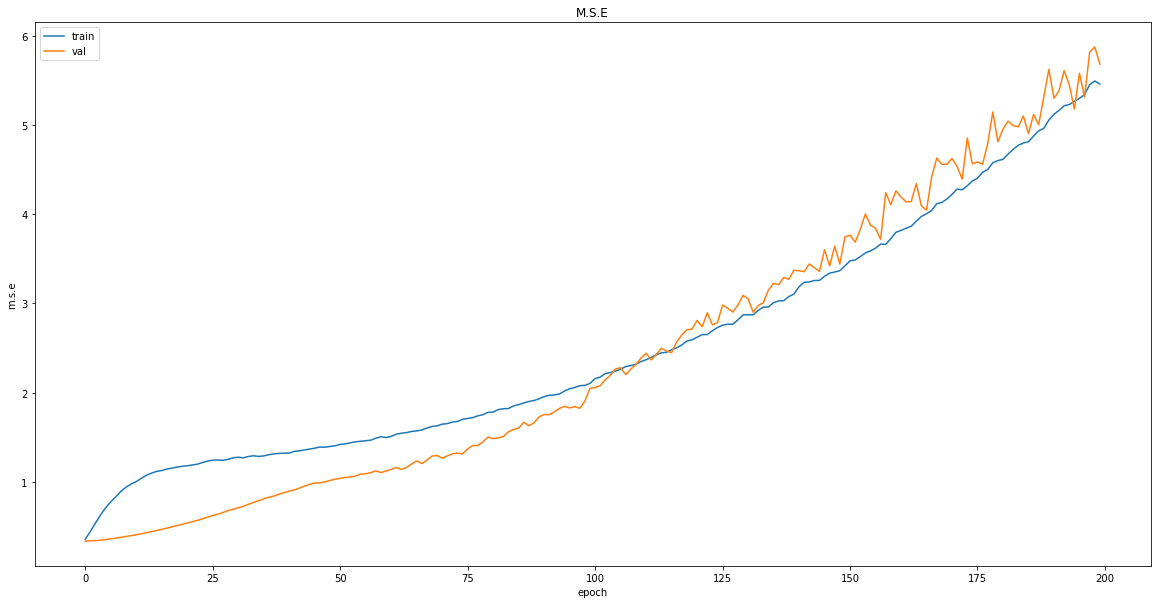

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [70]:
# Save model
model.save("models/{}".format('midea_time_series_lstm_buy_hold_sell_no_close.model'))

INFO:tensorflow:Assets written to: models/midea_time_series_lstm_buy_hold_sell_no_close.model\assets


### Test Performance

### non-recession

In [71]:
logger = []

In [72]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22    42.090000  39.647816 -10.142844  258783172.0     2.0
2019-01-23    41.299999  39.901998 -21.428571  234314954.0     2.0
2019-01-24    41.459999  40.141691 -19.142859  253542262.0     2.0
2019-01-25    41.590000  40.364507 -19.706827  275498548.0     2.0
2019-01-28    41.900002  40.600737 -14.705848  302253363.0     2.0


In [73]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [74]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [75]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(207, 15, 3)

In [76]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [77]:
model = tf.keras.models.load_model("models/midea_time_series_lstm_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.1669 - accuracy: 0.7971 - mean_squared_error: 5.1215 - weighted_accuracy: 0.7971 - weighted_mean_squared_error: 5.1215
Test loss: 0.16688655316829681
Test accuracy: 0.7971014380455017


In [78]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 8, 2: 181, 0: 18})

In [79]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 186, 0: 10, 1: 11})

In [80]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)

In [81]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,46.400002,44.456141,-30.862341,419918481.0,2.0,1,2
2019-02-19,46.080002,44.755197,-13.767016,452488699.0,2.0,2,2
2019-02-20,46.080002,44.959013,-18.975880,424412835.0,2.0,2,2
2019-02-21,45.860001,45.131473,-18.975880,424412835.0,2.0,2,2
2019-02-22,45.610001,45.243554,-26.174460,382970560.0,2.0,2,2


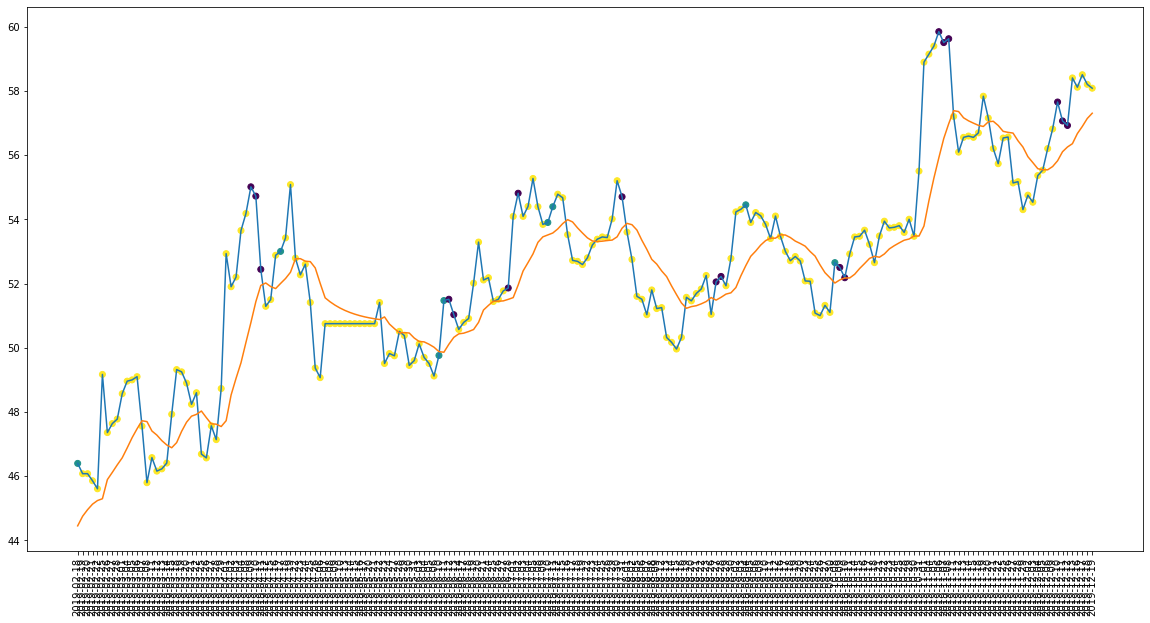

In [82]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

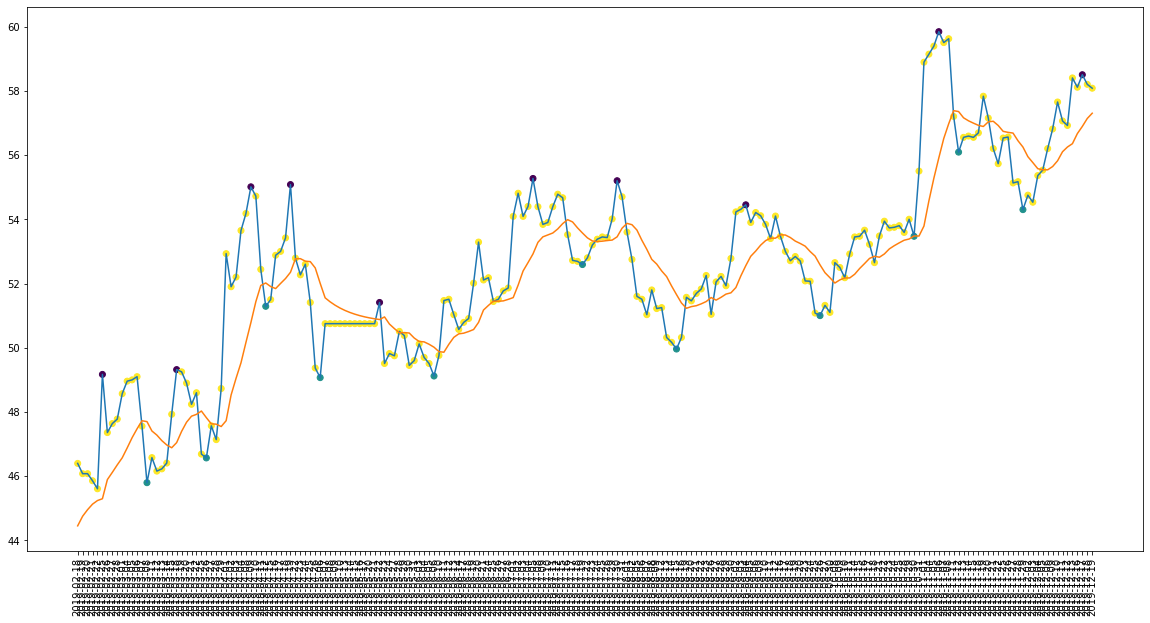

In [83]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [84]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 207
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 7
actual holds but predicted sell: 16
actual predicted holds: 163
Percentage buys correct: 0.0%
Percentage sells correct: 20.0%
Percentage holds correct: 87.63440860215054%
actual buys: 11
actual sells: 10
actual holds: 186


In [85]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[45.61000061035156, 45.86000061035156, 46.08000183105469, 46.08000183105469, 46.4000015258789, 47.36000061035156, 47.63999938964844, 47.77999877929688, 49.16999816894531]
[45.79999923706055, 47.36000061035156, 47.56000137329102, 47.63999938964844, 47.77999877929688, 48.56999969482422, 48.959999084472656, 49.0, 49.099998474121094]
Percentage buys correct: 25.0%
Percentage sells correct: 55.55555555555556%
Percentage holds correct: 78.88888888888889%


In [86]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $46.4000015258789
Shares owned at the moment: 214
Cash capital at the moment: $43.0932725639359


Price increase from previously bought: 18.230892013582924%
Share price: $55.0099983215332
Shares owned at the moment: 0
Cash capital at the moment: $11782.85952935982


Share price: $53.0
Shares owned at the moment: 221
Cash capital at the moment: $37.648779359818946


Stop Loss Activated!

Share price: $51.40999984741211
Shares owned at the moment: 0
Cash capital at the moment: $11368.01431823063


Share price: $49.7599983215332
Shares owned at the moment: 227
Cash capital at the moment: $41.43202029037457


Price increase from previously bought: 9.846642036050213%
Share price: $54.81000137329102
Shares owned at the moment: 0
Cash capital at the moment: $12449.087188670159


Share price: $53.9000015258789
Shares owned at the moment: 230
Cash capital at the moment: $17.995086752893258


Stop Loss Activated!

Share price: $51.599998474121094
Shares owned at the moment: 0
Cash c

In [87]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12438.033583332062
profit gained: 24.380335833320625%


In [88]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.801932,9.090909090909092%,18.181818181818183%,88.10810810810811%,57.142857142857146%,42.10526315789474%,85.0828729281768%,8.337400863952626%,55.56771999603271%
1,0.788462,0.0%,10.0%,86.24338624338624%,85.71428571428571%,50.0%,84.5303867403315%,13.828872050170867%,67.54069125000002%
2,0.797101,0.0%,20.0%,87.63440860215054%,25.0%,55.55555555555556%,78.88888888888889%,28.98050285001758%,24.380335833320625%


### recession

In [89]:
logger = []

In [90]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    58.099998  59.163333 -58.000031  68400881.0     2.0
2020-01-23    57.480000  58.904359 -70.400009  27240262.0     2.0
2020-02-03    55.029999  58.308304 -99.500020 -27633268.0     1.0
2020-02-04    50.189999  57.059334 -94.741468 -98139988.0     2.0
2020-02-05    52.790001  56.402513 -71.954419 -57726889.0     2.0


In [91]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [92]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [93]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(208, 15, 3)

In [94]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [95]:
model = tf.keras.models.load_model("models/midea_time_series_lstm_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1745 - accuracy: 0.7548 - mean_squared_error: 5.2914 - weighted_accuracy: 0.7548 - weighted_mean_squared_error: 5.2914
Test loss: 0.17452789843082428
Test accuracy: 0.754807710647583


In [96]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 172, 0: 23, 1: 13})

In [97]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 8, 1: 7})

In [98]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df.set_index('Date', inplace=True)

In [99]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,53.540001,54.301035,-52.927131,-33290149.0,2.0,2,2
2020-02-20,54.860001,54.183953,-44.755246,-9557295.0,2.0,2,2
2020-02-21,54.279999,54.287960,-8.665511,27483857.0,2.0,2,2
2020-02-24,54.910000,54.286736,-21.343904,-2296012.0,0.0,2,0
2020-02-25,54.430000,54.382622,-12.602723,38486402.0,2.0,0,2


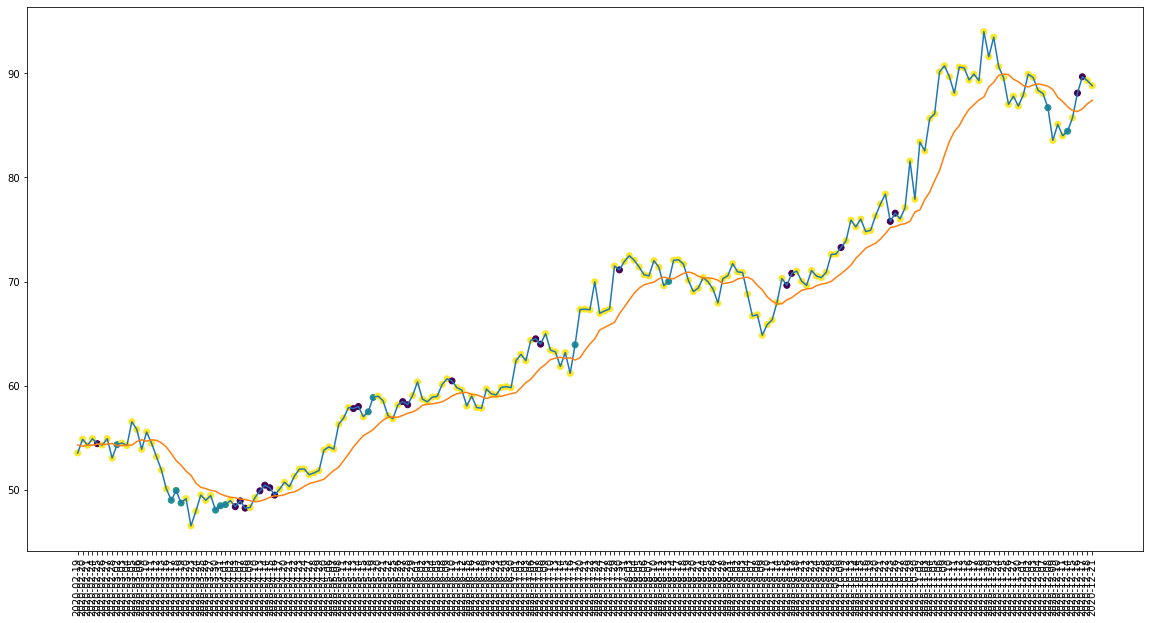

In [100]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

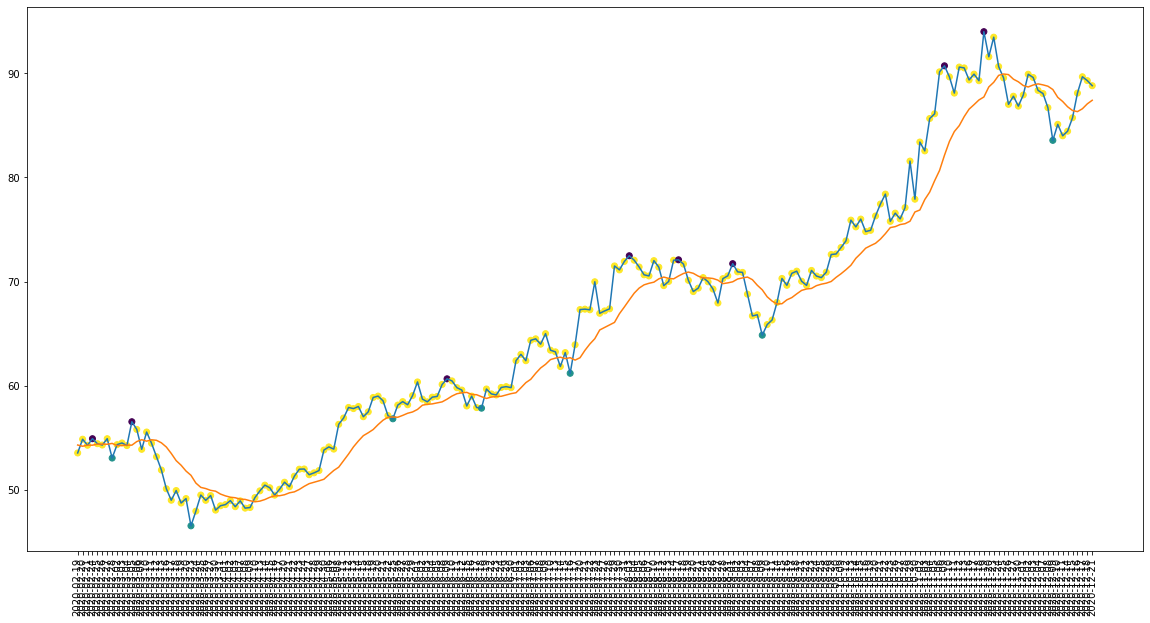

In [101]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [102]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 208
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 13
actual holds but predicted sell: 23
actual predicted holds: 157
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 81.34715025906736%
actual buys: 7
actual sells: 8
actual holds: 193


In [103]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[53.04999923706055, 53.540000915527344, 54.27999877929688, 54.29999923706055, 54.34000015258789, 54.43000030517578, 54.86000061035156, 54.90999984741211, 54.90999984741211]
[53.04999923706055, 53.88999938964844, 54.25, 54.34000015258789, 54.5, 54.90999984741211, 55.54999923706055, 55.79999923706055, 56.540000915527344]
Percentage buys correct: 61.53846153846154%
Percentage sells correct: 56.52173913043478%
Percentage holds correct: 83.62573099415205%


In [104]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $54.34000015258789
Shares owned at the moment: 183
Cash capital at the moment: $28.43336699962674


Stop Loss Activated!

Share price: $51.9000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9500.014970467566


Share price: $49.0
Shares owned at the moment: 193
Cash capital at the moment: $17.00822046756548


Stop Loss Activated!

Share price: $46.540000915527344
Shares owned at the moment: 0
Cash capital at the moment: $8974.527291678427


Share price: $48.04999923706055
Shares owned at the moment: 186
Cash capital at the moment: $12.649858975408279


Price increase from previously bought: 19.96146944458581%
Share price: $57.79999923706055
Shares owned at the moment: 0
Cash capital at the moment: $10733.885017458913


Share price: $57.4900016784668
Shares owned at the moment: 186
Cash capital at the moment: $11.338569405552335


Price increase from previously bought: 11.885735894182226%
Share price: $64.5
Shares owned at the moment: 0
Cash capital at 

In [105]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16487.407351390837
profit gained: 64.87407351390837%


In [106]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.801932,9.090909090909092%,18.181818181818183%,88.10810810810811%,57.142857142857146%,42.10526315789474%,85.0828729281768%,8.337400863952626%,55.56771999603271%
1,0.788462,0.0%,10.0%,86.24338624338624%,85.71428571428571%,50.0%,84.5303867403315%,13.828872050170867%,67.54069125000002%
2,0.797101,0.0%,20.0%,87.63440860215054%,25.0%,55.55555555555556%,78.88888888888889%,28.98050285001758%,24.380335833320625%
3,0.754808,0.0%,0.0%,81.34715025906736%,61.53846153846154%,56.52173913043478%,83.62573099415205%,29.36893413418762%,64.87407351390837%


## Walmart

In [107]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
1  2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2  2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
3  2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
4  2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


In [108]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [109]:
df.set_index('Date', inplace=True)
df.head()

,EMA_12,willr_14,OBV_7,labels
Date,,,,
2000-01-21,65.176128,-85.271318,-26649200.0,2.0
2000-01-24,64.754801,-94.594595,-33601700.0,2.0
2000-01-25,63.927139,-83.606557,-41401600.0,2.0
2000-01-26,63.496041,-68.306011,-34997800.0,2.0
2000-01-27,63.256265,-61.202186,-30459400.0,2.0


In [110]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [111]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
X.shape

(4745, 15, 3)

In [112]:
y = labels
y = np.array(y)

In [113]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [114]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [115]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [116]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [117]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 33ms/step - loss: 0.2812 - accuracy: 0.4842 - mse: 0.4909 - weighted_accuracy: 0.3562 - weighted_mse: 0.5559 - val_loss: 0.3003 - val_accuracy: 0.0485 - val_mse: 0.3478 - val_weighted_accuracy: 0.0485 - val_weighted_mse: 0.3478
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2092 - accuracy: 0.2829 - mse: 0.8152 - weighted_accuracy: 0.4205 - weighted_mse: 0.8006 - val_loss: 0.2915 - val_accuracy: 0.0453 - val_mse: 0.3759 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3759
Epoch 3/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1900 - accuracy: 0.2850 - mse: 1.0328 - weighted_accuracy: 0.4900 - weighted_mse: 1.0152 - val_loss: 0.2823 - val_accuracy: 0.0453 - val_mse: 0.4095 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4095
Epoch 4/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1828 - accuracy: 0.2819 - mse: 1.1540 - weighted_accuracy: 0.5071 - weighte

Epoch 30/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1405 - accuracy: 0.3662 - mse: 1.5936 - weighted_accuracy: 0.7005 - weighted_mse: 1.4989 - val_loss: 0.1855 - val_accuracy: 0.3846 - val_mse: 1.5703 - val_weighted_accuracy: 0.3846 - val_weighted_mse: 1.5703
Epoch 31/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1391 - accuracy: 0.3699 - mse: 1.6083 - weighted_accuracy: 0.6946 - weighted_mse: 1.5169 - val_loss: 0.2004 - val_accuracy: 0.2771 - val_mse: 1.6782 - val_weighted_accuracy: 0.2771 - val_weighted_mse: 1.6782
Epoch 32/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1385 - accuracy: 0.3725 - mse: 1.6165 - weighted_accuracy: 0.7027 - weighted_mse: 1.5231 - val_loss: 0.1963 - val_accuracy: 0.3087 - val_mse: 1.7147 - val_weighted_accuracy: 0.3087 - val_weighted_mse: 1.7147
Epoch 33/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1380 - accuracy: 0.3844 - mse: 1.6195 - weighted_accuracy: 0.7124 - weig

Epoch 59/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1177 - accuracy: 0.5366 - mse: 1.9619 - weighted_accuracy: 0.7902 - weighted_mse: 1.8902 - val_loss: 0.2040 - val_accuracy: 0.3962 - val_mse: 2.1002 - val_weighted_accuracy: 0.3962 - val_weighted_mse: 2.1002
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1181 - accuracy: 0.5103 - mse: 2.0275 - weighted_accuracy: 0.7661 - weighted_mse: 1.9545 - val_loss: 0.1859 - val_accuracy: 0.4605 - val_mse: 2.1716 - val_weighted_accuracy: 0.4605 - val_weighted_mse: 2.1716
Epoch 61/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1158 - accuracy: 0.5211 - mse: 1.9937 - weighted_accuracy: 0.7953 - weighted_mse: 1.9234 - val_loss: 0.1884 - val_accuracy: 0.4268 - val_mse: 2.0268 - val_weighted_accuracy: 0.4268 - val_weighted_mse: 2.0268
Epoch 62/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1154 - accuracy: 0.5290 - mse: 2.0254 - weighted_accuracy: 0.7964 - weig

Epoch 88/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0966 - accuracy: 0.6309 - mse: 2.4631 - weighted_accuracy: 0.8502 - weighted_mse: 2.4329 - val_loss: 0.1642 - val_accuracy: 0.6038 - val_mse: 2.7246 - val_weighted_accuracy: 0.6038 - val_weighted_mse: 2.7246
Epoch 89/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0981 - accuracy: 0.6591 - mse: 2.4877 - weighted_accuracy: 0.8460 - weighted_mse: 2.4641 - val_loss: 0.2212 - val_accuracy: 0.4078 - val_mse: 2.5191 - val_weighted_accuracy: 0.4078 - val_weighted_mse: 2.5191
Epoch 90/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0986 - accuracy: 0.6286 - mse: 2.5014 - weighted_accuracy: 0.8438 - weighted_mse: 2.4587 - val_loss: 0.1714 - val_accuracy: 0.5764 - val_mse: 2.5918 - val_weighted_accuracy: 0.5764 - val_weighted_mse: 2.5918
Epoch 91/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0967 - accuracy: 0.6560 - mse: 2.5649 - weighted_accuracy: 0.8430 - wei

Epoch 117/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0824 - accuracy: 0.7242 - mse: 3.1775 - weighted_accuracy: 0.8823 - weighted_mse: 3.1347 - val_loss: 0.2052 - val_accuracy: 0.5321 - val_mse: 3.1947 - val_weighted_accuracy: 0.5321 - val_weighted_mse: 3.1947
Epoch 118/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0793 - accuracy: 0.7150 - mse: 3.1264 - weighted_accuracy: 0.8881 - weighted_mse: 3.1090 - val_loss: 0.1765 - val_accuracy: 0.6091 - val_mse: 3.4436 - val_weighted_accuracy: 0.6091 - val_weighted_mse: 3.4436
Epoch 119/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0795 - accuracy: 0.7131 - mse: 3.2346 - weighted_accuracy: 0.8857 - weighted_mse: 3.1817 - val_loss: 0.1523 - val_accuracy: 0.6976 - val_mse: 3.3613 - val_weighted_accuracy: 0.6976 - val_weighted_mse: 3.3613
Epoch 120/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0786 - accuracy: 0.7447 - mse: 3.1956 - weighted_accuracy: 0.8991 - 

Epoch 146/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0642 - accuracy: 0.7948 - mse: 4.2095 - weighted_accuracy: 0.9101 - weighted_mse: 4.0768 - val_loss: 0.1823 - val_accuracy: 0.6502 - val_mse: 4.6137 - val_weighted_accuracy: 0.6502 - val_weighted_mse: 4.6137
Epoch 147/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0645 - accuracy: 0.7945 - mse: 4.1886 - weighted_accuracy: 0.9102 - weighted_mse: 4.0176 - val_loss: 0.1665 - val_accuracy: 0.7060 - val_mse: 4.4795 - val_weighted_accuracy: 0.7060 - val_weighted_mse: 4.4795
Epoch 148/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0657 - accuracy: 0.7890 - mse: 4.2442 - weighted_accuracy: 0.9117 - weighted_mse: 4.0688 - val_loss: 0.1943 - val_accuracy: 0.6259 - val_mse: 4.3123 - val_weighted_accuracy: 0.6259 - val_weighted_mse: 4.3123
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0621 - accuracy: 0.8069 - mse: 4.2471 - weighted_accuracy: 0.9237 - 

Epoch 175/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0500 - accuracy: 0.8501 - mse: 5.4566 - weighted_accuracy: 0.9432 - weighted_mse: 5.1142 - val_loss: 0.1841 - val_accuracy: 0.7187 - val_mse: 5.9698 - val_weighted_accuracy: 0.7187 - val_weighted_mse: 5.9698
Epoch 176/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0472 - accuracy: 0.8588 - mse: 5.5134 - weighted_accuracy: 0.9482 - weighted_mse: 5.1423 - val_loss: 0.1886 - val_accuracy: 0.7113 - val_mse: 5.9295 - val_weighted_accuracy: 0.7113 - val_weighted_mse: 5.9295
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0506 - accuracy: 0.8556 - mse: 5.5392 - weighted_accuracy: 0.9379 - weighted_mse: 5.2279 - val_loss: 0.1992 - val_accuracy: 0.6754 - val_mse: 5.5036 - val_weighted_accuracy: 0.6754 - val_weighted_mse: 5.5036
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0512 - accuracy: 0.8498 - mse: 5.5431 - weighted_accuracy: 0.9358 - 

In [118]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.2041184902191162
Test accuracy: 0.748155951499939


In [119]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-4.2440796  -0.88243693  0.17031519]
 [-1.678528   -2.1666348   0.5408923 ]
 [ 0.16341127 -5.5079966  -1.0498905 ]
 ...
 [-4.2659383   0.61012864 -1.5543422 ]
 [-2.0976646  -4.270932    1.4705114 ]
 [-1.7608836  -5.3290176   1.5743067 ]]


Counter({2: 787, 0: 81, 1: 81})

In [120]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 44, 1: 43})

In [121]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 1
actual buys but predicted sell: 2
actual buys but predicted hold: 40
actual sells but predicted buy: 2
actual predicted sells: 2
actual sells but predicted hold: 40
actual holds but predicted buy: 78
actual holds but predicted sell: 77
actual predicted holds: 707
Percentage buys correct: 2.3255813953488373%
Percentage sells correct: 4.545454545454546%
Percentage holds correct: 82.01856148491879%
actual buys: 43
actual sells: 44
actual holds: 862


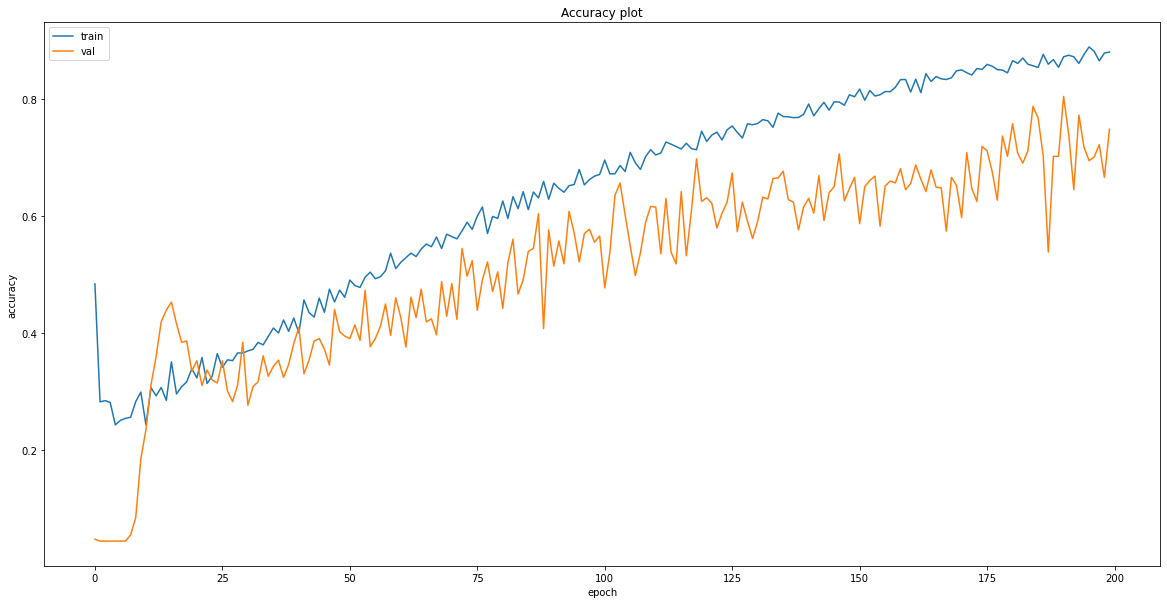

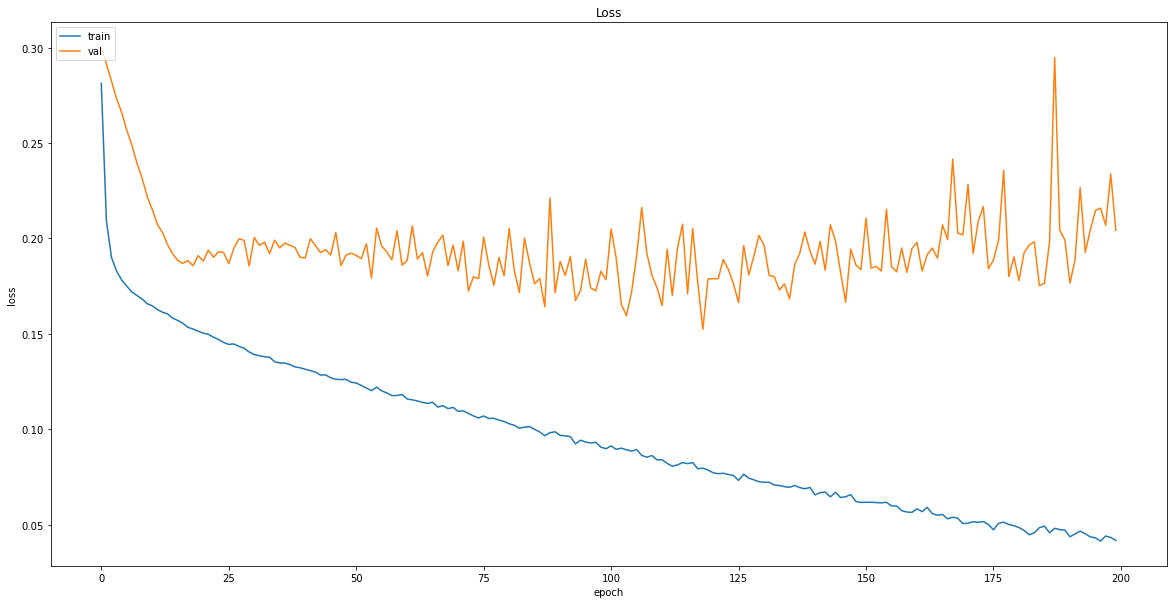

In [122]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [123]:
# Save model
model.save("models/{}".format('WMT_time_series_lstm_buy_hold_sell_no_close.model'))

INFO:tensorflow:Assets written to: models/WMT_time_series_lstm_buy_hold_sell_no_close.model\assets


### Test Performance

### non-recession

In [124]:
logger = []

In [125]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    97.730003  95.334462  -7.164539  58918700.0     2.0
2019-01-23    97.489998  95.666083 -13.843922  50855500.0     0.0
2019-01-24    98.709999  96.134378  -9.609606  59201300.0     2.0
2019-01-25    98.360001  96.476781 -14.864842  51591600.0     2.0
2019-01-28    96.940002  96.548046 -38.683751  44373400.0     2.0


In [126]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [127]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(218, 15, 3)

In [128]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [129]:
model = tf.keras.models.load_model("models/WMT_time_series_lstm_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1327 - accuracy: 0.7844 - mean_squared_error: 6.7022 - weighted_accuracy: 0.7844 - weighted_mean_squared_error: 6.7022
Test loss: 0.13274061679840088
Test accuracy: 0.7844036817550659


In [130]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 183, 1: 16, 0: 19})

In [131]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [132]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df.set_index('Date', inplace=True)

In [133]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,96.199997,95.814812,-60.416634,53751900.0,2.0,2,2
2019-02-12,96.970001,95.874072,-50.480811,59294700.0,2.0,2,2
2019-02-13,97.940002,96.042676,-33.448300,65176000.0,2.0,2,2
2019-02-14,98.519997,96.334572,-16.724150,70634500.0,2.0,2,2
2019-02-15,99.989998,96.670792,-11.165857,77835300.0,2.0,2,2


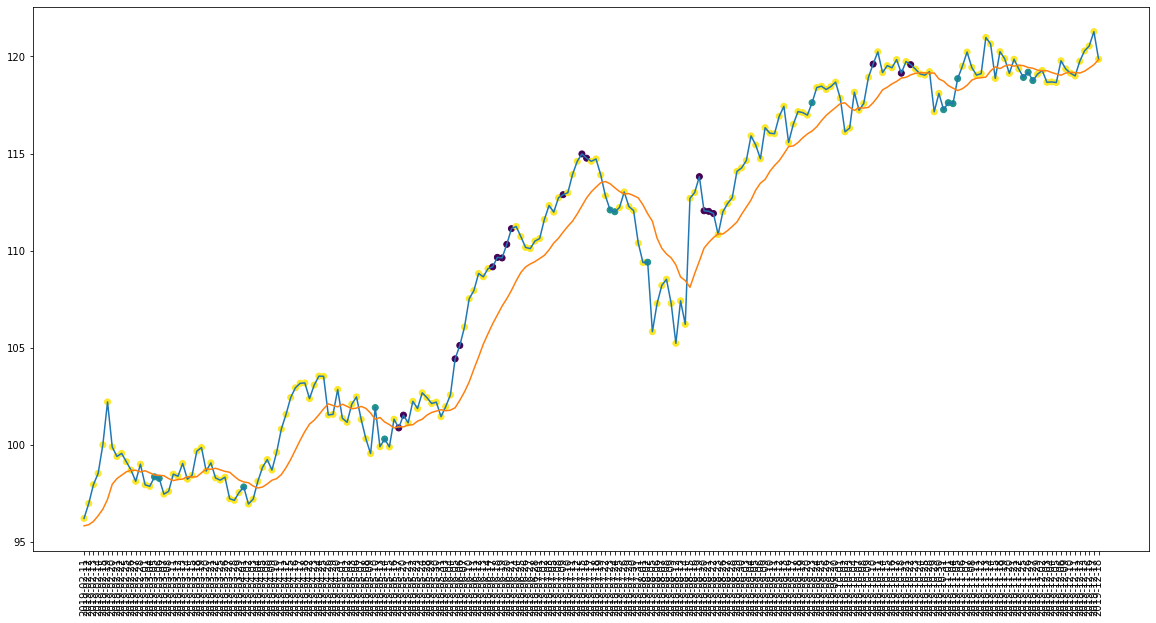

In [134]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

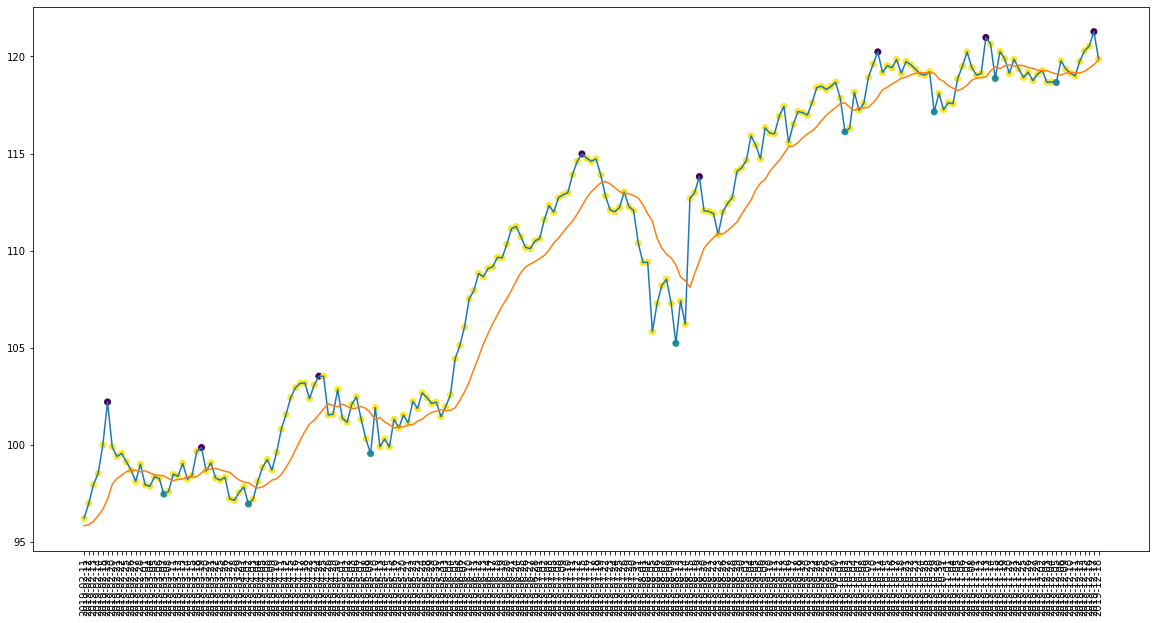

In [135]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [136]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 6
actual holds but predicted buy: 16
actual holds but predicted sell: 17
actual predicted holds: 169
Percentage buys correct: 0.0%
Percentage sells correct: 25.0%
Percentage holds correct: 83.66336633663366%
actual buys: 8
actual sells: 8
actual holds: 202


In [137]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[96.1999969482422, 96.97000122070312, 97.94000244140624, 98.5199966430664, 99.38999938964844, 99.5500030517578, 99.87999725341795, 99.98999786376952, 102.1999969482422]
[97.8499984741211, 97.93000030517578, 98.11000061035156, 98.69000244140624, 98.98999786376952, 99.12000274658205, 99.38999938964844, 99.5500030517578, 99.87999725341795]
Percentage buys correct: 50.0%
Percentage sells correct: 52.63157894736842%
Percentage holds correct: 84.61538461538461%


In [138]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $98.33999633789062
Shares owned at the moment: 101
Cash capital at the moment: $40.346435890198336


Price increase from previously bought: 5.891432339254465%
Share price: $104.41999816894531
Shares owned at the moment: 0
Cash capital at the moment: $10557.76359646225


Share price: $112.08999633789062
Shares owned at the moment: 93
Cash capital at the moment: $104.72692047500641


Stop Loss Activated!

Share price: $105.81999969482422
Shares owned at the moment: 0
Cash capital at the moment: $9918.923427171707


Share price: $117.62000274658205
Shares owned at the moment: 84
Cash capital at the moment: $11.672975824352761




Capital at the end of test period: $10052.225366952893
profit gained: 0.5222536695289273%


In [139]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12375.78138288879
profit gained: 23.7578138288879%


In [140]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.801932,9.090909090909092%,18.181818181818183%,88.10810810810811%,57.142857142857146%,42.10526315789474%,85.0828729281768%,8.337400863952626%,55.56771999603271%
1,0.788462,0.0%,10.0%,86.24338624338624%,85.71428571428571%,50.0%,84.5303867403315%,13.828872050170867%,67.54069125000002%
2,0.797101,0.0%,20.0%,87.63440860215054%,25.0%,55.55555555555556%,78.88888888888889%,28.98050285001758%,24.380335833320625%
3,0.754808,0.0%,0.0%,81.34715025906736%,61.53846153846154%,56.52173913043478%,83.62573099415205%,29.36893413418762%,64.87407351390837%
4,0.784404,0.0%,25.0%,83.66336633663366%,50.0%,52.63157894736842%,84.61538461538461%,0.5222536695289273%,23.7578138288879%


### Recession

In [141]:
logger = []

In [142]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   115.589996  116.459043 -80.074504 -17684500.0     2.0
2020-01-23   116.099998  116.403805 -70.577262 -12758400.0     2.0
2020-01-24   115.809998  116.312450 -69.789236 -17063500.0     2.0
2020-01-27   114.370003  116.013612 -94.416205 -21446900.0     2.0
2020-01-28   115.860001  115.989979 -34.297465 -14428500.0     2.0


In [143]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [144]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(219, 15, 3)

In [145]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [146]:
model = tf.keras.models.load_model("models/WMT_time_series_lstm_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1452 - accuracy: 0.8219 - mean_squared_error: 7.7403 - weighted_accuracy: 0.8219 - weighted_mean_squared_error: 7.7403
Test loss: 0.1452340930700302
Test accuracy: 0.8219178318977356


In [147]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 192, 1: 16, 0: 11})

In [148]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [149]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)

In [150]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,115.400002,115.836459,-43.516528,-17373100.0,2.0,2,2
2020-02-12,115.849998,115.769312,-40.219793,-11576300.0,2.0,2,2
2020-02-13,117.440002,115.781725,-30.329757,-6840700.0,2.0,2,2
2020-02-14,117.889999,116.036845,-2.057582,-1507500.0,2.0,2,2
2020-02-18,119.629997,116.321946,-14.561040,6623100.0,0.0,2,0


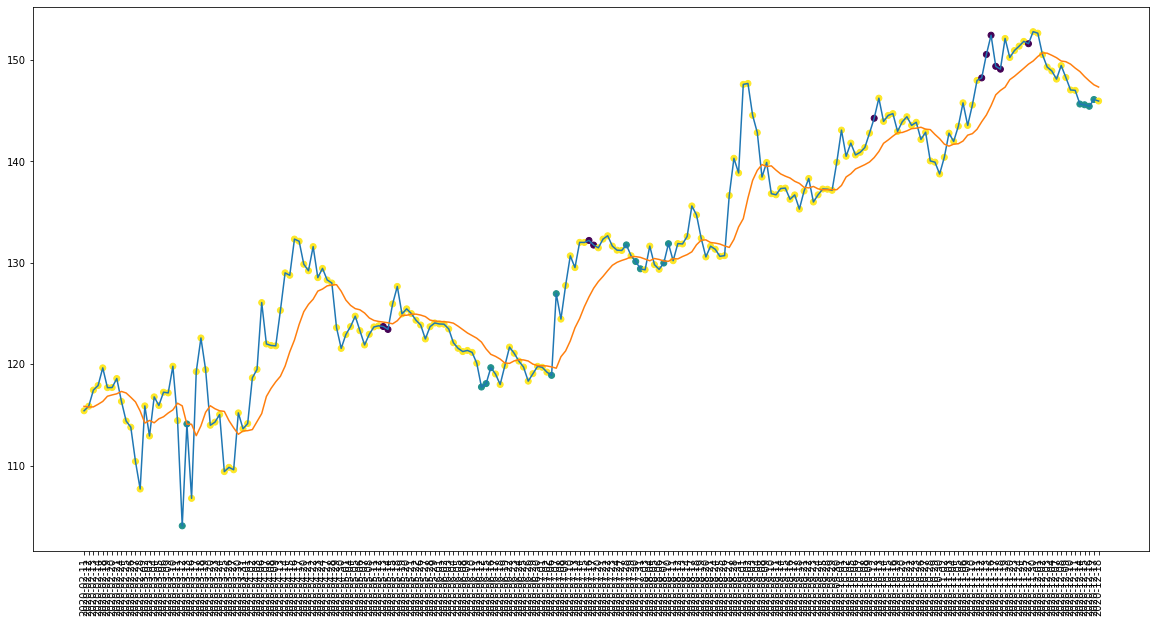

In [151]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

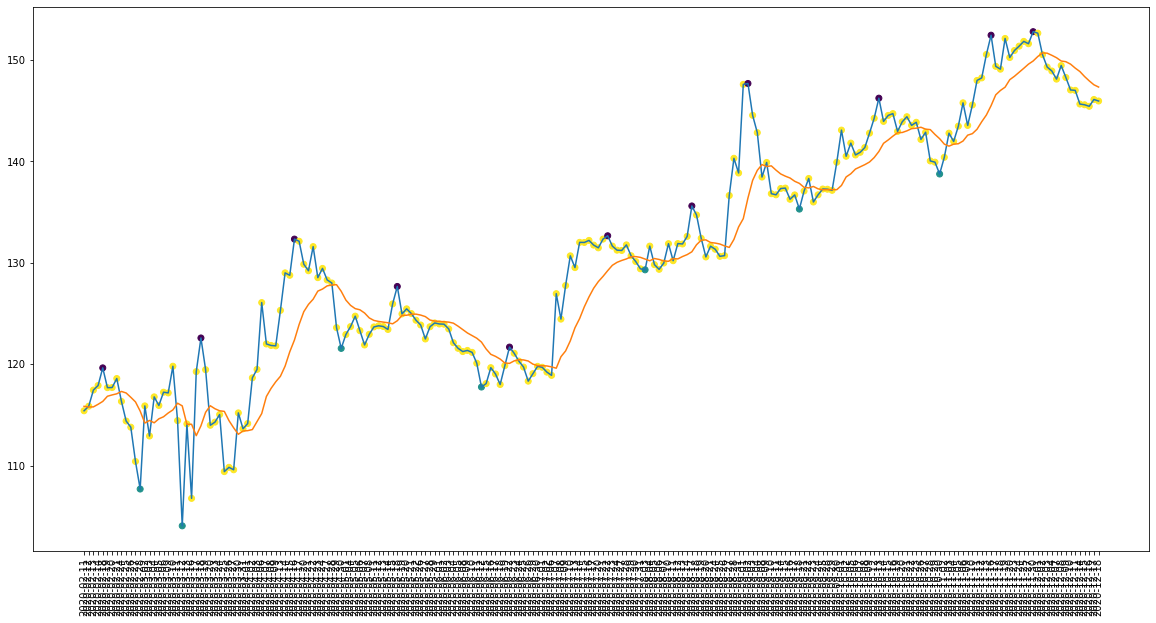

In [152]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [153]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 10
actual holds but predicted buy: 14
actual holds but predicted sell: 10
actual predicted holds: 177
Percentage buys correct: 28.571428571428573%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 88.05970149253731%
actual buys: 7
actual sells: 11
actual holds: 201


In [154]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[115.4000015258789, 115.8499984741211, 116.31999969482422, 117.44000244140624, 117.68000030517578, 117.69000244140624, 117.88999938964844, 118.58000183105469, 119.62999725341795]
[107.68000030517578, 110.4000015258789, 112.91000366210938, 113.77999877929688, 114.38999938964844, 115.87999725341795, 116.31999969482422, 117.69000244140624, 118.58000183105469]
Percentage buys correct: 68.75%
Percentage sells correct: 45.45454545454545%
Percentage holds correct: 85.86387434554973%


In [155]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $104.0500030517578
Shares owned at the moment: 95
Cash capital at the moment: $88.06664678573725


Price increase from previously bought: 18.568693858436735%
Share price: $123.70999908447266
Shares owned at the moment: 0
Cash capital at the moment: $11808.19732254982


Share price: $117.73999786376952
Shares owned at the moment: 100
Cash capital at the moment: $1.8190367603328923


Price increase from previously bought: 11.973370451260301%
Share price: $132.19999694824222
Shares owned at the moment: 0
Cash capital at the moment: $13185.463732423788


Share price: $131.75999450683594
Shares owned at the moment: 99
Cash capital at the moment: $105.35261774254468


Price increase from previously bought: 9.179118394270724%
Share price: $144.25
Shares owned at the moment: 0
Cash capital at the moment: $14346.830555242545


Share price: $145.64999389648438
Shares owned at the moment: 98
Cash capital at the moment: $33.878480031973595




Capital at the end of test period: $14297

In [156]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12565.490331684112
profit gained: 25.65490331684112%


In [157]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.801932,9.090909090909092%,18.181818181818183%,88.10810810810811%,57.142857142857146%,42.10526315789474%,85.0828729281768%,8.337400863952626%,55.56771999603271%
1,0.788462,0.0%,10.0%,86.24338624338624%,85.71428571428571%,50.0%,84.5303867403315%,13.828872050170867%,67.54069125000002%
2,0.797101,0.0%,20.0%,87.63440860215054%,25.0%,55.55555555555556%,78.88888888888889%,28.98050285001758%,24.380335833320625%
3,0.754808,0.0%,0.0%,81.34715025906736%,61.53846153846154%,56.52173913043478%,83.62573099415205%,29.36893413418762%,64.87407351390837%
4,0.784404,0.0%,25.0%,83.66336633663366%,50.0%,52.63157894736842%,84.61538461538461%,0.5222536695289273%,23.7578138288879%
5,0.821918,28.571428571428573%,9.090909090909092%,88.05970149253731%,68.75%,45.45454545454545%,85.86387434554973%,42.97644656782157%,25.65490331684112%


## Fresh Del Monte Produce Inc

In [158]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14     OBV_7  labels
0  2000-01-21       8.7500  8.946622 -66.666667   78200.0     2.0
1  2000-01-24       8.8750  8.935603 -58.333333   99900.0     2.0
2  2000-01-25       9.0000  8.945511 -50.000000  123600.0     2.0
3  2000-01-26       8.6875  8.905817 -70.833333   87300.0     2.0
4  2000-01-27       8.5625  8.852999 -76.000000   32400.0     2.0


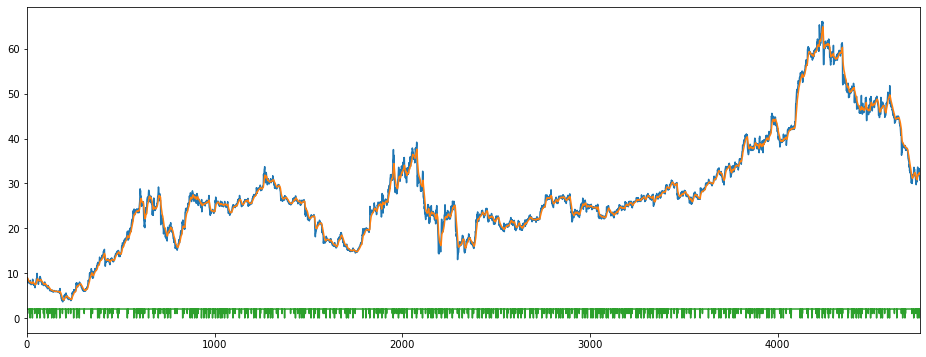

In [159]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [160]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,8.7500,8.946622,-66.666667,78200.0,2.0
2000-01-24,8.8750,8.935603,-58.333333,99900.0,2.0
2000-01-25,9.0000,8.945511,-50.000000,123600.0,2.0
2000-01-26,8.6875,8.905817,-70.833333,87300.0,2.0
2000-01-27,8.5625,8.852999,-76.000000,32400.0,2.0


In [161]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [162]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(4745, 15, 3)

In [163]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [164]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [165]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [166]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [167]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 34ms/step - loss: 0.2829 - accuracy: 0.4974 - mse: 0.4649 - weighted_accuracy: 0.3432 - weighted_mse: 0.5374 - val_loss: 0.3001 - val_accuracy: 0.0569 - val_mse: 0.3474 - val_weighted_accuracy: 0.0569 - val_weighted_mse: 0.3474
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 0.2112 - accuracy: 0.3670 - mse: 0.7911 - weighted_accuracy: 0.4308 - weighted_mse: 0.7979 - val_loss: 0.2911 - val_accuracy: 0.0464 - val_mse: 0.3760 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3760
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1921 - accuracy: 0.3641 - mse: 0.9980 - weighted_accuracy: 0.4679 - weighted_mse: 0.9991 - val_loss: 0.2812 - val_accuracy: 0.0464 - val_mse: 0.4109 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.4109
Epoch 4/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1842 - accuracy: 0.3462 - mse: 1.1206 - weighted_accuracy: 0.5086 - weighte

Epoch 30/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1486 - accuracy: 0.3891 - mse: 1.4581 - weighted_accuracy: 0.6617 - weighted_mse: 1.3873 - val_loss: 0.1895 - val_accuracy: 0.3720 - val_mse: 1.4566 - val_weighted_accuracy: 0.3720 - val_weighted_mse: 1.4566
Epoch 31/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1487 - accuracy: 0.4286 - mse: 1.4693 - weighted_accuracy: 0.6798 - weighted_mse: 1.4054 - val_loss: 0.1887 - val_accuracy: 0.3888 - val_mse: 1.4440 - val_weighted_accuracy: 0.3888 - val_weighted_mse: 1.4440
Epoch 32/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1464 - accuracy: 0.4223 - mse: 1.4710 - weighted_accuracy: 0.6757 - weighted_mse: 1.4084 - val_loss: 0.1747 - val_accuracy: 0.4721 - val_mse: 1.4223 - val_weighted_accuracy: 0.4721 - val_weighted_mse: 1.4223
Epoch 33/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1467 - accuracy: 0.4170 - mse: 1.4823 - weighted_accuracy: 0.6756 - weig

Epoch 59/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1265 - accuracy: 0.5527 - mse: 1.6637 - weighted_accuracy: 0.7489 - weighted_mse: 1.6131 - val_loss: 0.1735 - val_accuracy: 0.5121 - val_mse: 1.6867 - val_weighted_accuracy: 0.5121 - val_weighted_mse: 1.6867
Epoch 60/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1269 - accuracy: 0.5411 - mse: 1.6618 - weighted_accuracy: 0.7464 - weighted_mse: 1.6010 - val_loss: 0.1789 - val_accuracy: 0.4974 - val_mse: 1.7327 - val_weighted_accuracy: 0.4974 - val_weighted_mse: 1.7327
Epoch 61/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1266 - accuracy: 0.5287 - mse: 1.6889 - weighted_accuracy: 0.7383 - weighted_mse: 1.6152 - val_loss: 0.1827 - val_accuracy: 0.4837 - val_mse: 1.7634 - val_weighted_accuracy: 0.4837 - val_weighted_mse: 1.7634
Epoch 62/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1263 - accuracy: 0.5566 - mse: 1.6999 - weighted_accuracy: 0.7448 - weig

Epoch 88/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1057 - accuracy: 0.6436 - mse: 1.9534 - weighted_accuracy: 0.8293 - weighted_mse: 1.8804 - val_loss: 0.1781 - val_accuracy: 0.5469 - val_mse: 2.0578 - val_weighted_accuracy: 0.5469 - val_weighted_mse: 2.0578
Epoch 89/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1062 - accuracy: 0.6496 - mse: 2.0043 - weighted_accuracy: 0.8207 - weighted_mse: 1.9454 - val_loss: 0.1766 - val_accuracy: 0.5543 - val_mse: 2.1625 - val_weighted_accuracy: 0.5543 - val_weighted_mse: 2.1625
Epoch 90/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1047 - accuracy: 0.6546 - mse: 2.0004 - weighted_accuracy: 0.8389 - weighted_mse: 1.9359 - val_loss: 0.1574 - val_accuracy: 0.6344 - val_mse: 2.0753 - val_weighted_accuracy: 0.6344 - val_weighted_mse: 2.0753
Epoch 91/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1050 - accuracy: 0.6486 - mse: 2.0568 - weighted_accuracy: 0.8330 - weig

Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0860 - accuracy: 0.7347 - mse: 2.4451 - weighted_accuracy: 0.8845 - weighted_mse: 2.3615 - val_loss: 0.1751 - val_accuracy: 0.5827 - val_mse: 2.6446 - val_weighted_accuracy: 0.5827 - val_weighted_mse: 2.6446
Epoch 118/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0864 - accuracy: 0.7281 - mse: 2.4904 - weighted_accuracy: 0.8839 - weighted_mse: 2.3922 - val_loss: 0.1595 - val_accuracy: 0.6565 - val_mse: 2.6551 - val_weighted_accuracy: 0.6565 - val_weighted_mse: 2.6551
Epoch 119/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0842 - accuracy: 0.7381 - mse: 2.5055 - weighted_accuracy: 0.8840 - weighted_mse: 2.4330 - val_loss: 0.1598 - val_accuracy: 0.6481 - val_mse: 2.7544 - val_weighted_accuracy: 0.6481 - val_weighted_mse: 2.7544
Epoch 120/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0849 - accuracy: 0.7547 - mse: 2.5440 - weighted_accuracy: 0.8882 - 

Epoch 146/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0719 - accuracy: 0.7969 - mse: 3.2415 - weighted_accuracy: 0.9055 - weighted_mse: 3.0648 - val_loss: 0.1628 - val_accuracy: 0.6955 - val_mse: 3.5392 - val_weighted_accuracy: 0.6955 - val_weighted_mse: 3.5392
Epoch 147/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0688 - accuracy: 0.7964 - mse: 3.2510 - weighted_accuracy: 0.9180 - weighted_mse: 3.0609 - val_loss: 0.1799 - val_accuracy: 0.6670 - val_mse: 3.4348 - val_weighted_accuracy: 0.6670 - val_weighted_mse: 3.4348
Epoch 148/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0685 - accuracy: 0.8001 - mse: 3.3103 - weighted_accuracy: 0.9103 - weighted_mse: 3.1147 - val_loss: 0.1833 - val_accuracy: 0.6438 - val_mse: 3.5256 - val_weighted_accuracy: 0.6438 - val_weighted_mse: 3.5256
Epoch 149/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0688 - accuracy: 0.8027 - mse: 3.3450 - weighted_accuracy: 0.9149 - 

30/30 [==============================] - 0s 8ms/step - loss: 0.0551 - accuracy: 0.8454 - mse: 4.2928 - weighted_accuracy: 0.9378 - weighted_mse: 3.9067 - val_loss: 0.1696 - val_accuracy: 0.7345 - val_mse: 4.7859 - val_weighted_accuracy: 0.7345 - val_weighted_mse: 4.7859
Epoch 175/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0562 - accuracy: 0.8388 - mse: 4.3362 - weighted_accuracy: 0.9336 - weighted_mse: 3.9292 - val_loss: 0.1850 - val_accuracy: 0.7007 - val_mse: 4.6325 - val_weighted_accuracy: 0.7007 - val_weighted_mse: 4.6325
Epoch 176/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0574 - accuracy: 0.8401 - mse: 4.2940 - weighted_accuracy: 0.9322 - weighted_mse: 3.9537 - val_loss: 0.1835 - val_accuracy: 0.7050 - val_mse: 4.8135 - val_weighted_accuracy: 0.7050 - val_weighted_mse: 4.8135
Epoch 177/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0553 - accuracy: 0.8443 - mse: 4.3911 - weighted_accuracy: 0.9338 - weighted_mse: 

In [168]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.19085702300071716
Test accuracy: 0.741833508014679


In [169]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.6431775  -1.6232388   0.7075754 ]
 [-0.93144256 -3.9756334   0.6968234 ]
 [-1.0599895  -3.7800171   0.8457249 ]
 ...
 [ 1.0710195  -3.364114   -2.1146064 ]
 [-0.5780225  -2.1813838   0.15730481]
 [ 0.55661386 -3.10476    -0.8083189 ]]


Counter({2: 760, 0: 107, 1: 82})

In [170]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 43, 1: 44})

In [171]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 8
actual buys but predicted sell: 3
actual buys but predicted hold: 33
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 37
actual holds but predicted buy: 74
actual holds but predicted sell: 98
actual predicted holds: 690
Percentage buys correct: 18.181818181818183%
Percentage sells correct: 13.953488372093023%
Percentage holds correct: 80.04640371229698%
actual buys: 44
actual sells: 43
actual holds: 862


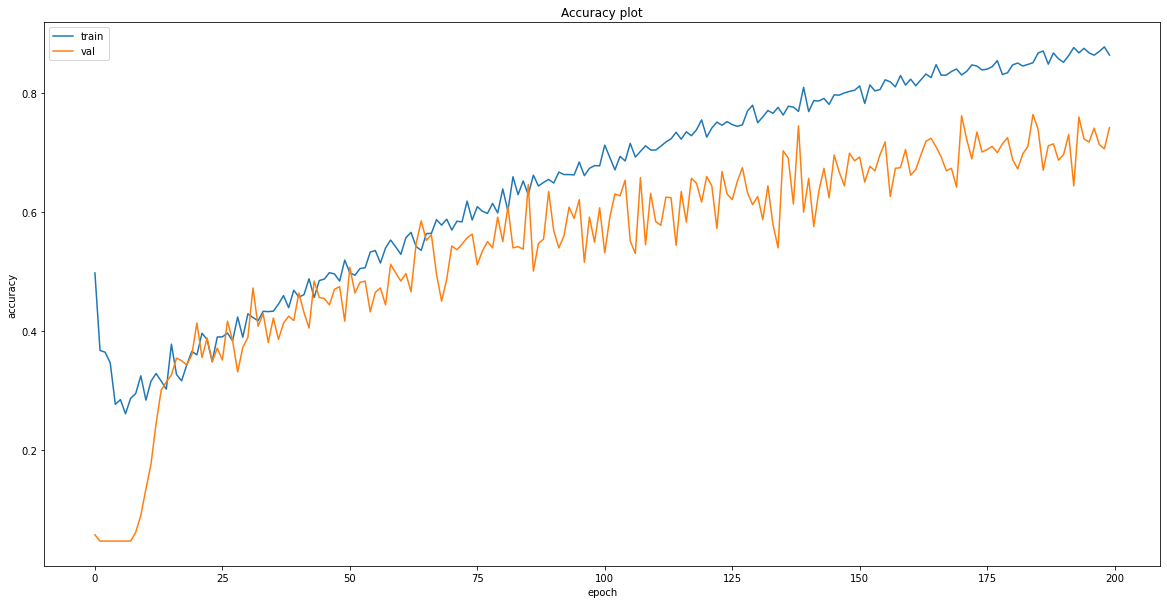

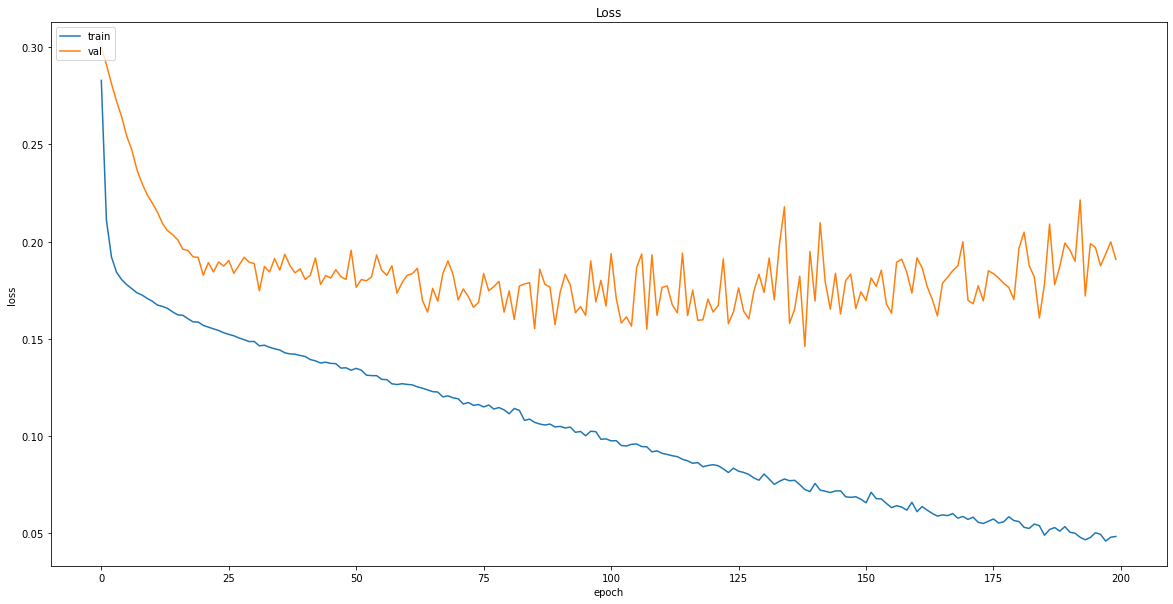

In [172]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [173]:
# Save model
model.save("models/{}".format('FDP_time_series_lstm_buy_hold_sell_no_close.model'))

INFO:tensorflow:Assets written to: models/FDP_time_series_lstm_buy_hold_sell_no_close.model\assets


### Test Performance

### non-recession

In [174]:
logger = []

In [175]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2019-01-22    30.219999  29.918096 -32.033467  1515700.0     2.0
2019-01-23    30.480000  30.004543 -24.791121  1646600.0     2.0
2019-01-24    30.459999  30.074613 -28.980936  1528300.0     2.0
2019-01-25    30.639999  30.161596 -35.265743  1632300.0     2.0
2019-01-28    30.879999  30.272119 -23.671560  1731100.0     2.0


In [176]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [177]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(218, 15, 3)

In [178]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [179]:
model = tf.keras.models.load_model("models/FDP_time_series_lstm_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.1809 - accuracy: 0.7661 - mean_squared_error: 6.3474 - weighted_accuracy: 0.7661 - weighted_mean_squared_error: 6.3474
Test loss: 0.1809166967868805
Test accuracy: 0.7660550475120544


In [180]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 173, 0: 28, 1: 17})

In [181]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [182]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)

In [183]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,33.880001,31.978904,-0.753738,2502700.0,2.0,2,2
2019-02-12,34.610001,32.271381,-0.536205,2611700.0,2.0,0,2
2019-02-13,34.810001,32.631168,-5.603413,2713000.0,2.0,0,2
2019-02-14,34.430000,32.966373,-5.668932,2794100.0,2.0,0,2
2019-02-15,35.220001,33.191547,-14.285733,2675800.0,0.0,2,0


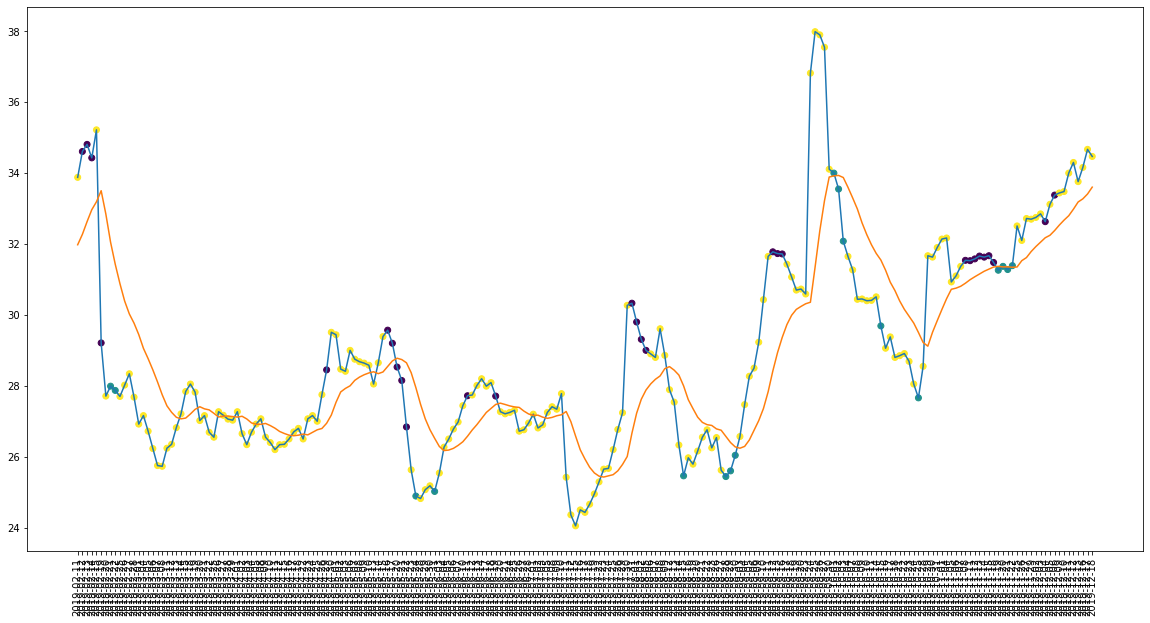

In [184]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

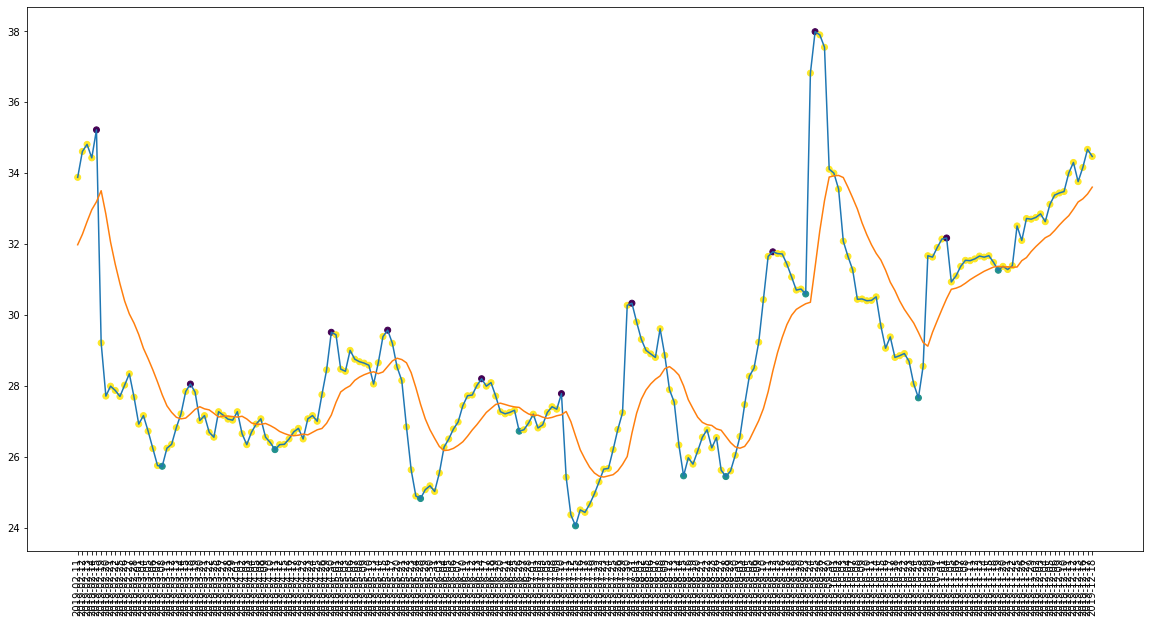

In [185]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [186]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 13
actual holds but predicted sell: 25
actual predicted holds: 160
Percentage buys correct: 40.0%
Percentage sells correct: 30.0%
Percentage holds correct: 80.8080808080808%
actual buys: 10
actual sells: 10
actual holds: 198


In [187]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[27.709999084472656, 27.8700008392334, 27.989999771118164, 29.209999084472656, 33.880001068115234, 34.43000030517578, 34.610000610351555, 34.810001373291016, 35.220001220703125]
[26.920000076293945, 27.15999984741211, 27.68000030517578, 27.70000076293945, 27.709999084472656, 27.8700008392334, 27.989999771118164, 28.020000457763672, 28.34000015258789]
Percentage buys correct: 76.47058823529412%
Percentage sells correct: 53.57142857142857%
Percentage holds correct: 84.88372093023256%


In [188]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $27.989999771118164
Shares owned at the moment: 356
Cash capital at the moment: $8.157871706009246


Stop Loss Activated!

Share price: $26.920000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9565.323218791962


Share price: $24.88999938964844
Shares owned at the moment: 383
Cash capital at the moment: $6.23806069946113


Price increase from previously bought: 11.0646004448121%
Share price: $27.71999931335449
Shares owned at the moment: 0
Cash capital at the moment: $10593.801708437439


Share price: $25.459999084472656
Shares owned at the moment: 414
Cash capital at the moment: $24.375878508086316


Price increase from previously bought: 24.480936769667316%
Share price: $31.78000068664551
Shares owned at the moment: 0
Cash capital at the moment: $13145.114631997581


Share price: $34.0
Shares owned at the moment: 385
Cash capital at the moment: $19.117131997581964


Stop Loss Activated!

Share price: $32.080001831054695
Shares owned at the moment: 0

In [189]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10118.19906801033
profit gained: 1.1819906801032993%


In [190]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.801932,9.090909090909092%,18.181818181818183%,88.10810810810811%,57.142857142857146%,42.10526315789474%,85.0828729281768%,8.337400863952626%,55.56771999603271%
1,0.788462,0.0%,10.0%,86.24338624338624%,85.71428571428571%,50.0%,84.5303867403315%,13.828872050170867%,67.54069125000002%
2,0.797101,0.0%,20.0%,87.63440860215054%,25.0%,55.55555555555556%,78.88888888888889%,28.98050285001758%,24.380335833320625%
3,0.754808,0.0%,0.0%,81.34715025906736%,61.53846153846154%,56.52173913043478%,83.62573099415205%,29.36893413418762%,64.87407351390837%
4,0.784404,0.0%,25.0%,83.66336633663366%,50.0%,52.63157894736842%,84.61538461538461%,0.5222536695289273%,23.7578138288879%
5,0.821918,28.571428571428573%,9.090909090909092%,88.05970149253731%,68.75%,45.45454545454545%,85.86387434554973%,42.97644656782157%,25.65490331684112%
6,0.766055,40.0%,30.0%,80.8080808080808%,76.47058823529412%,53.57142857142857%,84.88372093023256%,35.214005763459156%,1.1819906801032993%


### recession

In [191]:
logger = []

In [192]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2020-01-22    34.250000  34.338683 -60.666656  -55800.0     2.0
2020-01-23    34.130001  34.306578 -67.360995 -191000.0     2.0
2020-01-24    34.520000  34.339413 -36.764689   18500.0     2.0
2020-01-27    32.290001  34.024118 -98.555924 -130500.0     2.0
2020-01-28    32.160000  33.737331 -85.885906 -280200.0     2.0


In [193]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [194]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(219, 15, 3)

In [195]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [196]:
model = tf.keras.models.load_model("models/FDP_time_series_lstm_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.2187 - accuracy: 0.7397 - mean_squared_error: 6.1876 - weighted_accuracy: 0.7397 - weighted_mean_squared_error: 6.1876
Test loss: 0.21866384148597717
Test accuracy: 0.7397260069847107


In [197]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 23, 2: 178, 1: 18})

In [198]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [199]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)

In [200]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,33.930000,32.680842,-26.373606,310600.0,2.0,0,2
2020-02-12,34.410000,32.873020,-19.505473,431300.0,2.0,0,2
2020-02-13,34.240002,33.109478,-14.750004,582800.0,2.0,0,2
2020-02-14,34.480000,33.283405,-18.999958,490800.0,0.0,0,0
2020-02-18,34.009998,33.467496,-13.000011,587800.0,2.0,2,2


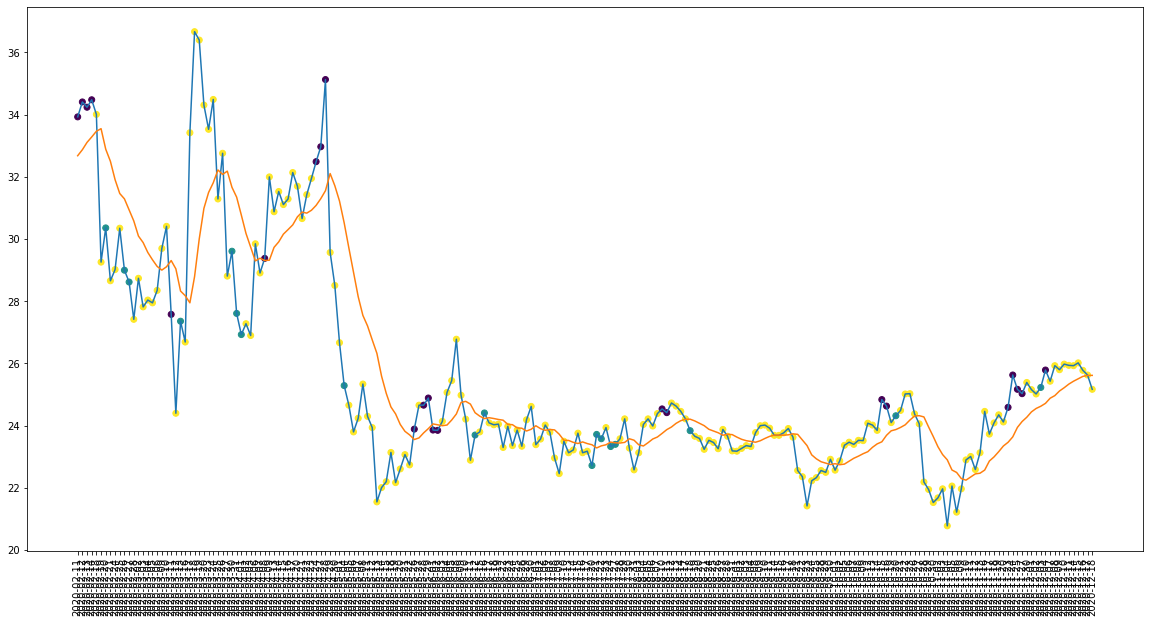

In [201]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

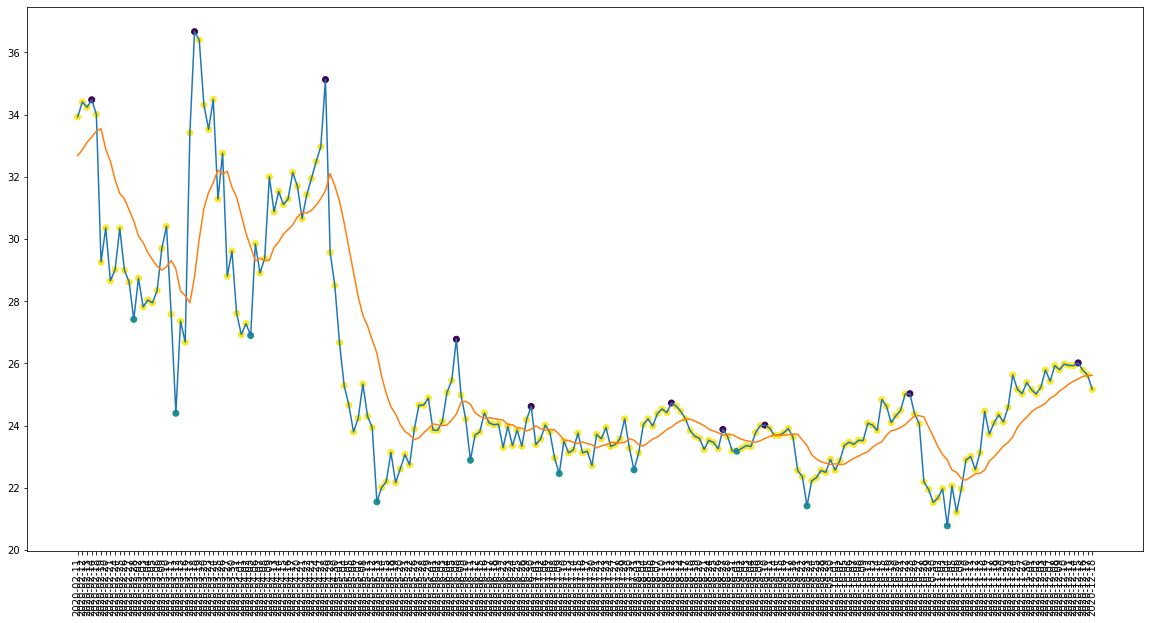

In [202]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [203]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 18
actual holds but predicted sell: 21
actual predicted holds: 160
Percentage buys correct: 0.0%
Percentage sells correct: 20.0%
Percentage holds correct: 80.40201005025126%
actual buys: 10
actual sells: 10
actual holds: 199


In [204]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[28.65999984741211, 29.020000457763672, 29.26000022888184, 30.36000061035156, 33.93000030517578, 34.009998321533196, 34.240001678466804, 34.40999984741211, 34.47999954223633]
[27.420000076293945, 27.81999969482422, 28.6200008392334, 28.65999984741211, 28.739999771118164, 29.0, 29.020000457763672, 30.35000038146973, 30.36000061035156]
Percentage buys correct: 61.111111111111114%
Percentage sells correct: 65.21739130434783%
Percentage holds correct: 82.48587570621469%


In [205]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $30.36000061035156
Shares owned at the moment: 328
Cash capital at the moment: $14.535079254152151


Stop Loss Activated!

Share price: $28.65999984741211
Shares owned at the moment: 0
Cash capital at the moment: $9389.163709342958


Share price: $29.0
Shares owned at the moment: 322
Cash capital at the moment: $25.48420934295791


Stop Loss Activated!

Share price: $27.420000076293945
Shares owned at the moment: 0
Cash capital at the moment: $8830.44382384205


Share price: $27.36000061035156
Shares owned at the moment: 321
Cash capital at the moment: $23.731587380412748


Price increase from previously bought: 7.088541982328467%
Share price: $29.3799991607666
Shares owned at the moment: 0
Cash capital at the moment: $9428.776123727324


Share price: $25.290000915527344
Shares owned at the moment: 371
Cash capital at the moment: $20.3836606326131


Stop Loss Activated!

Share price: $23.79999923706055
Shares owned at the moment: 0
Cash capital at the moment: $8825.9014283

In [206]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7385.700107630253
profit gained: -26.14299892369747%


In [207]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.801932,9.090909090909092%,18.181818181818183%,88.10810810810811%,57.142857142857146%,42.10526315789474%,85.0828729281768%,8.337400863952626%,55.56771999603271%
1,0.788462,0.0%,10.0%,86.24338624338624%,85.71428571428571%,50.0%,84.5303867403315%,13.828872050170867%,67.54069125000002%
2,0.797101,0.0%,20.0%,87.63440860215054%,25.0%,55.55555555555556%,78.88888888888889%,28.98050285001758%,24.380335833320625%
3,0.754808,0.0%,0.0%,81.34715025906736%,61.53846153846154%,56.52173913043478%,83.62573099415205%,29.36893413418762%,64.87407351390837%
4,0.784404,0.0%,25.0%,83.66336633663366%,50.0%,52.63157894736842%,84.61538461538461%,0.5222536695289273%,23.7578138288879%
5,0.821918,28.571428571428573%,9.090909090909092%,88.05970149253731%,68.75%,45.45454545454545%,85.86387434554973%,42.97644656782157%,25.65490331684112%
6,0.766055,40.0%,30.0%,80.8080808080808%,76.47058823529412%,53.57142857142857%,84.88372093023256%,35.214005763459156%,1.1819906801032993%
7,0.739726,0.0%,20.0%,80.40201005025126%,61.111111111111114%,65.21739130434783%,82.48587570621469%,-20.47492691343301%,-26.14299892369747%


In [208]:
experiment

'No close LSTM Time Series - noncyclic'

In [209]:
log.to_csv('{}.csv'.format(experiment))